# Grupo 5: Pronóstico Diario de Temperatura Máxima - Estación SENAMHI

Integrantes:

-Robert Pinedo

-Josmell Cordova

-Alessandra La Rosa


Se tiene un dataset de mediciones diarias provenientes de la estación meteorológica agrícola principal "Alcantarilla", localizada en la provincia de Huaura - Lima. Se cuentan con las siguientes variables meteorológicas: Precipitación Acumulada (PrecipAcum), Temperatura máxima del día (Tmax), y Temperatura mínima del día (Tmin).

**Se quiere pronosticar la temperatura máxima diaria (Tmax) de los siguientes 5 días.**

## Preprocesamiento inicial

Se realizará lo siguiente:
- Descartar la data anterior al 1 de enero de 2000
- Remover outliers notorios e imputarlos con interpolación lineal

Cargamos librerías

In [6]:
# Importamos librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
from sklearn.metrics import mean_squared_error   # para calcular el error cuadratico medio
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
plt.rcParams['figure.figsize'] = [8, 6]  #por defecto las figuras se displayan 8 pulgadas de ancho y 6 de alto

In [55]:
data_senahmi = pd.read_csv("datos_senamhi.csv", header = 0)

In [56]:
data_senahmi

,Anho,Mes,Dia,PrecipAcum,Tmax,Tmin
0,1967,1,8,0.0,-99.9,-99.9
1,1967,1,9,0.0,27.4,-99.9
2,1967,1,10,0.0,26.8,17.6
3,1967,1,11,0.0,26.4,17.6
4,1967,1,12,0.0,27.8,16.6
...,...,...,...,...,...,...
17306,2014,5,27,0.0,25.2,18.6
17307,2014,5,28,0.0,22.2,18.8
17308,2014,5,29,0.0,22.4,18.4
17309,2014,5,30,0.0,23.6,18.6


In [57]:
# Creamos una columna Date con la fecha de cada medición
for i in range(0, len(data_senahmi)):
    data_senahmi.loc[i, "Date"] = pd.to_datetime(datetime(data_senahmi.iloc[i,0],data_senahmi.iloc[i,1],data_senahmi.iloc[i,2]))

In [58]:
# Eliminamos columnas innecesarias
data_senahmi.drop(columns = ["Anho","Mes","Dia"], inplace = True)

In [59]:
# Establecemos la columna date como el índice
data_senahmi.set_index("Date", inplace = True)

In [60]:
data_senahmi.head()

,PrecipAcum,Tmax,Tmin
Date,,,
1967-01-08,0.0,-99.9,-99.9
1967-01-09,0.0,27.4,-99.9
1967-01-10,0.0,26.8,17.6
1967-01-11,0.0,26.4,17.6
1967-01-12,0.0,27.8,16.6


In [61]:
data_senahmi = data_senahmi["2000-01-01":] # Se elimina la data anterior al 1 de enero de 2000
data_senahmi

,PrecipAcum,Tmax,Tmin
Date,,,
2000-01-01,0.0,26.6,18.8
2000-01-02,0.0,27.0,18.4
2000-01-03,0.0,26.7,17.8
2000-01-04,0.0,26.8,17.0
2000-01-05,0.0,27.0,16.8
...,...,...,...
2014-05-27,0.0,25.2,18.6
2014-05-28,0.0,22.2,18.8
2014-05-29,0.0,22.4,18.4


Función para analizar gráficamente las series

In [14]:
def analizar_series_completo(serie, i): # se considera toda la data disponible de la serie
    # serie = nombre de variable de la serie
    # i = nombre de la medida
    # Creación de figura y subplots
    fig, ax = plt.subplots(5,1, figsize = (10,25))
    # Primer subplot
    serie.plot(ax = ax[0], title="Gráfico de líneas de la variable " + i, xlabel="Tiempo", ylabel = i)
    # Segundo subplot
    plot_acf(serie, lags = len(serie)-1, title="Autocorrelograma de " + i + " considerando " + str(len(serie)) + " semanas", ax=ax[1])
    # Tercer subplot
    plot_pacf(serie, lags = len(serie)/4, title="Autocorrelograma parcial de " + i + " considerando " + str(len(serie)/4) + " semanas", ax=ax[2])
    # Cuarto subplot
    serie.hist(bins = 50, ax = ax[3])
    ax[3].set_title("Histograma de la variable " + i)
    ax[3].set_xlabel(i)
    ax[3].set_ylabel("Frecuencia")
    # Quinto subplot
    serie.plot(kind="kde", ax = ax[4])
    ax[4].set_title("Densidad de la variable " + i)
    ax[4].set_xlabel(i)
    ax[4].set_ylabel("Densidad")
    # Mostrar la figura
    plt.tight_layout()
    plt.show()

In [63]:
PrecipAcum = data_senahmi["PrecipAcum"]
Tmax = data_senahmi["Tmax"]
Tmin = data_senahmi["Tmin"]

**PrecipAcum**

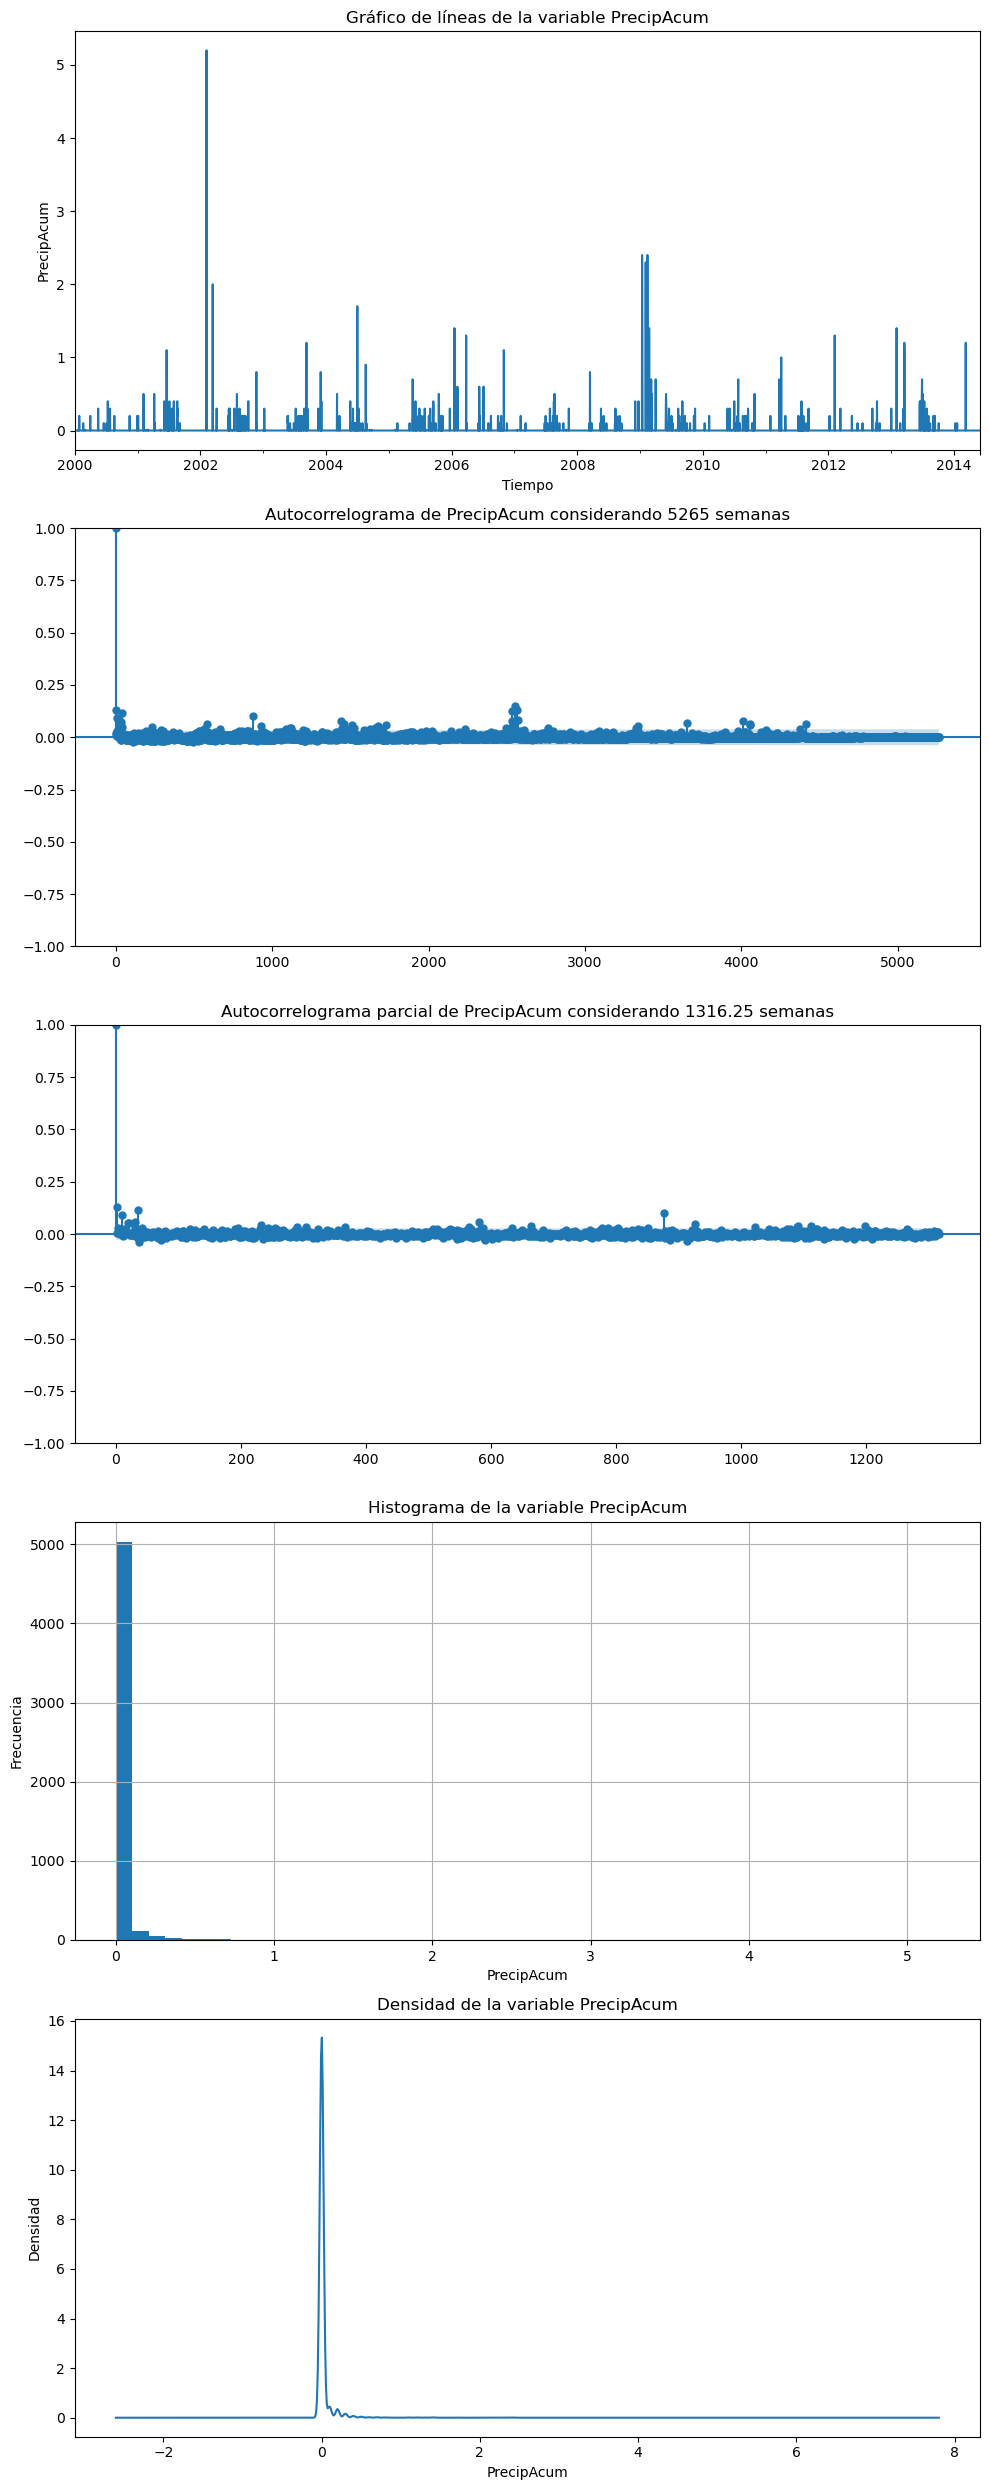

In [11]:
analizar_series_completo(PrecipAcum, "PrecipAcum")

In [16]:
PrecipAcum.describe()

count    5265.000000
mean        0.020995
std         0.133349
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.200000
Name: PrecipAcum, dtype: float64

In [17]:
PrecipAcum.value_counts()

PrecipAcum
0.00    4838
0.10     142
0.20     110
0.01      54
0.30      51
0.40      22
0.50      13
0.60       6
0.70       6
1.40       4
1.20       3
0.80       3
1.10       3
1.30       2
2.40       2
1.70       1
0.90       1
2.00       1
5.20       1
2.30       1
1.00       1
Name: count, dtype: int64

Se observa en las gráficas que no se tienen outliers notorios (por ej. valores negativos); sin embargo, se cuentan con algunos cuantos valores, aprox 100, que superan por mucho la media.
Por ahora, no se eliminarán esos outliers y se entrenarán los modelos con los datos actuales.

**Tmax**

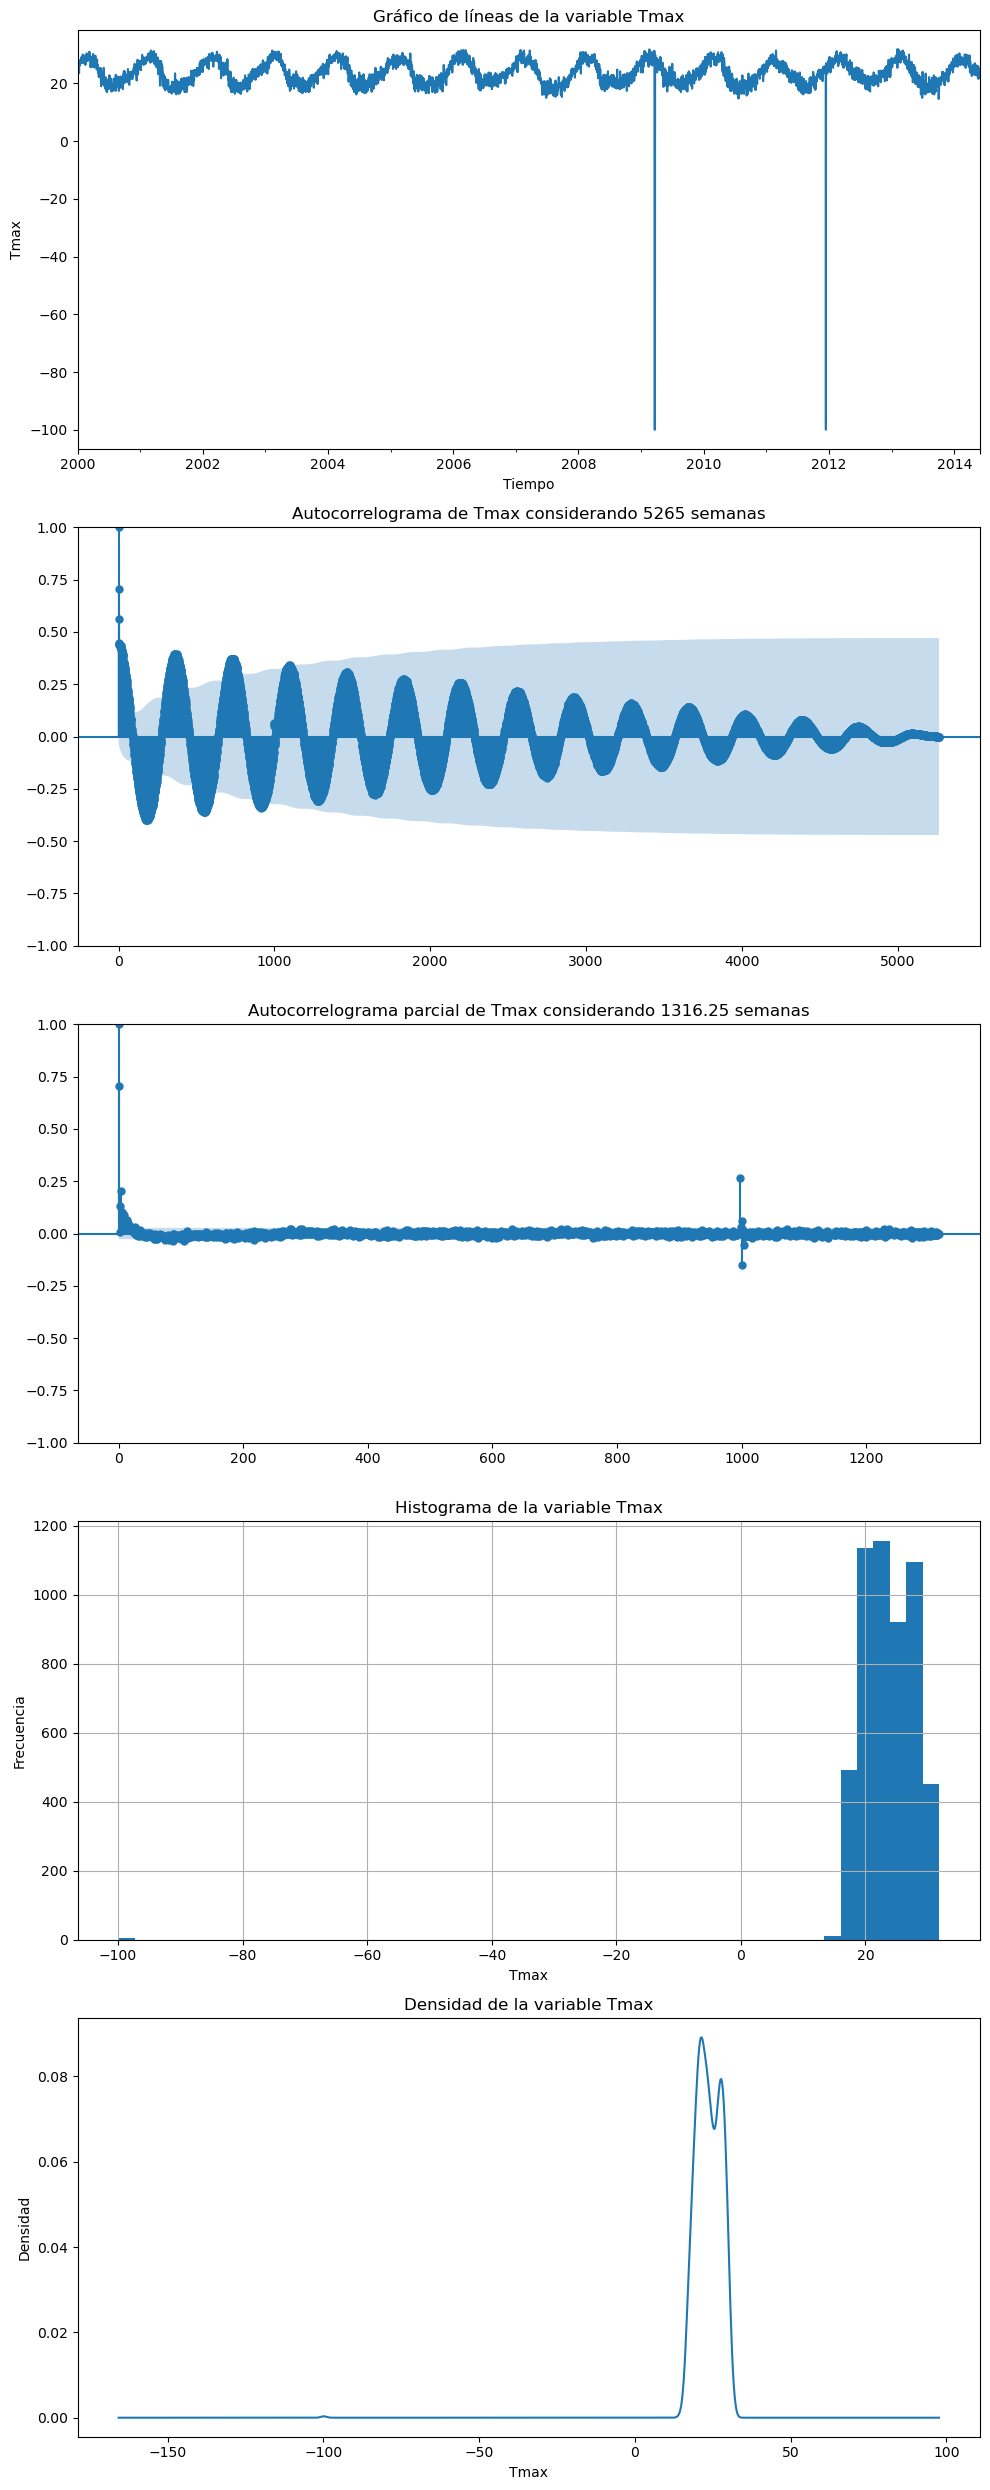

In [18]:
analizar_series_completo(Tmax, "Tmax")

In [19]:
Tmax.describe()

count    5265.000000
mean       23.650997
std         5.096269
min       -99.900000
25%        20.800000
50%        23.600000
75%        27.000000
max        31.800000
Name: Tmax, dtype: float64

In [20]:
Tmax[Tmax<0].value_counts()

Tmax
-99.9    4
Name: count, dtype: int64

En la serie Tmax se cuentan con 4 valores negativos, se interpolarán linealmente.

In [21]:
Tmax = Tmax.apply(lambda x: np.nan if x < 0 else x) # Los valores negativos se ponen como NaN

In [22]:
Tmax[Tmax<0].value_counts() # Ya no se observan los valores negativos

Series([], Name: count, dtype: int64)

In [23]:
Tmax.describe() # Se observa que antes se tenían 5265 valores, ahora 5261

count    5261.000000
mean       23.744934
std         3.791390
min        14.600000
25%        20.800000
50%        23.600000
75%        27.000000
max        31.800000
Name: Tmax, dtype: float64

In [24]:
Tmax = Tmax.interpolate(method="linear")

In [25]:
Tmax.describe() # Se volvieron a añadir los 4 valores

count    5265.000000
mean       23.749098
std         3.793201
min        14.600000
25%        20.800000
50%        23.600000
75%        27.100000
max        31.800000
Name: Tmax, dtype: float64

Text(0.5, 1.0, 'Serie Tmax con valores negativos eliminados')

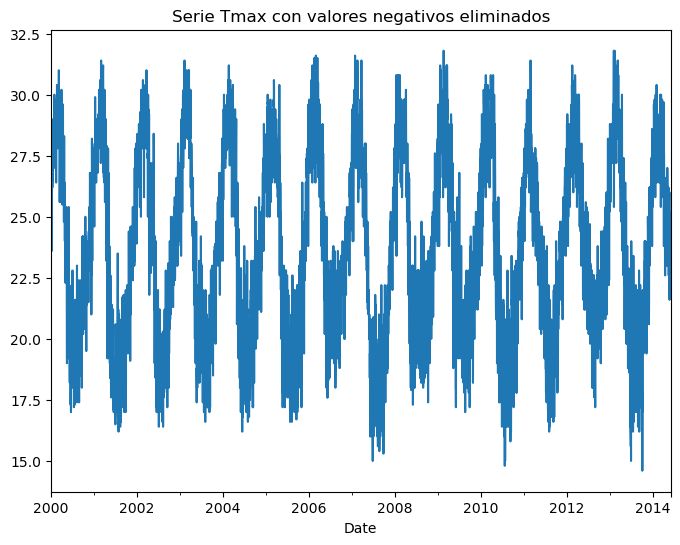

In [26]:
Tmax.plot()
plt.title("Serie Tmax con valores negativos eliminados")

**Tmin**

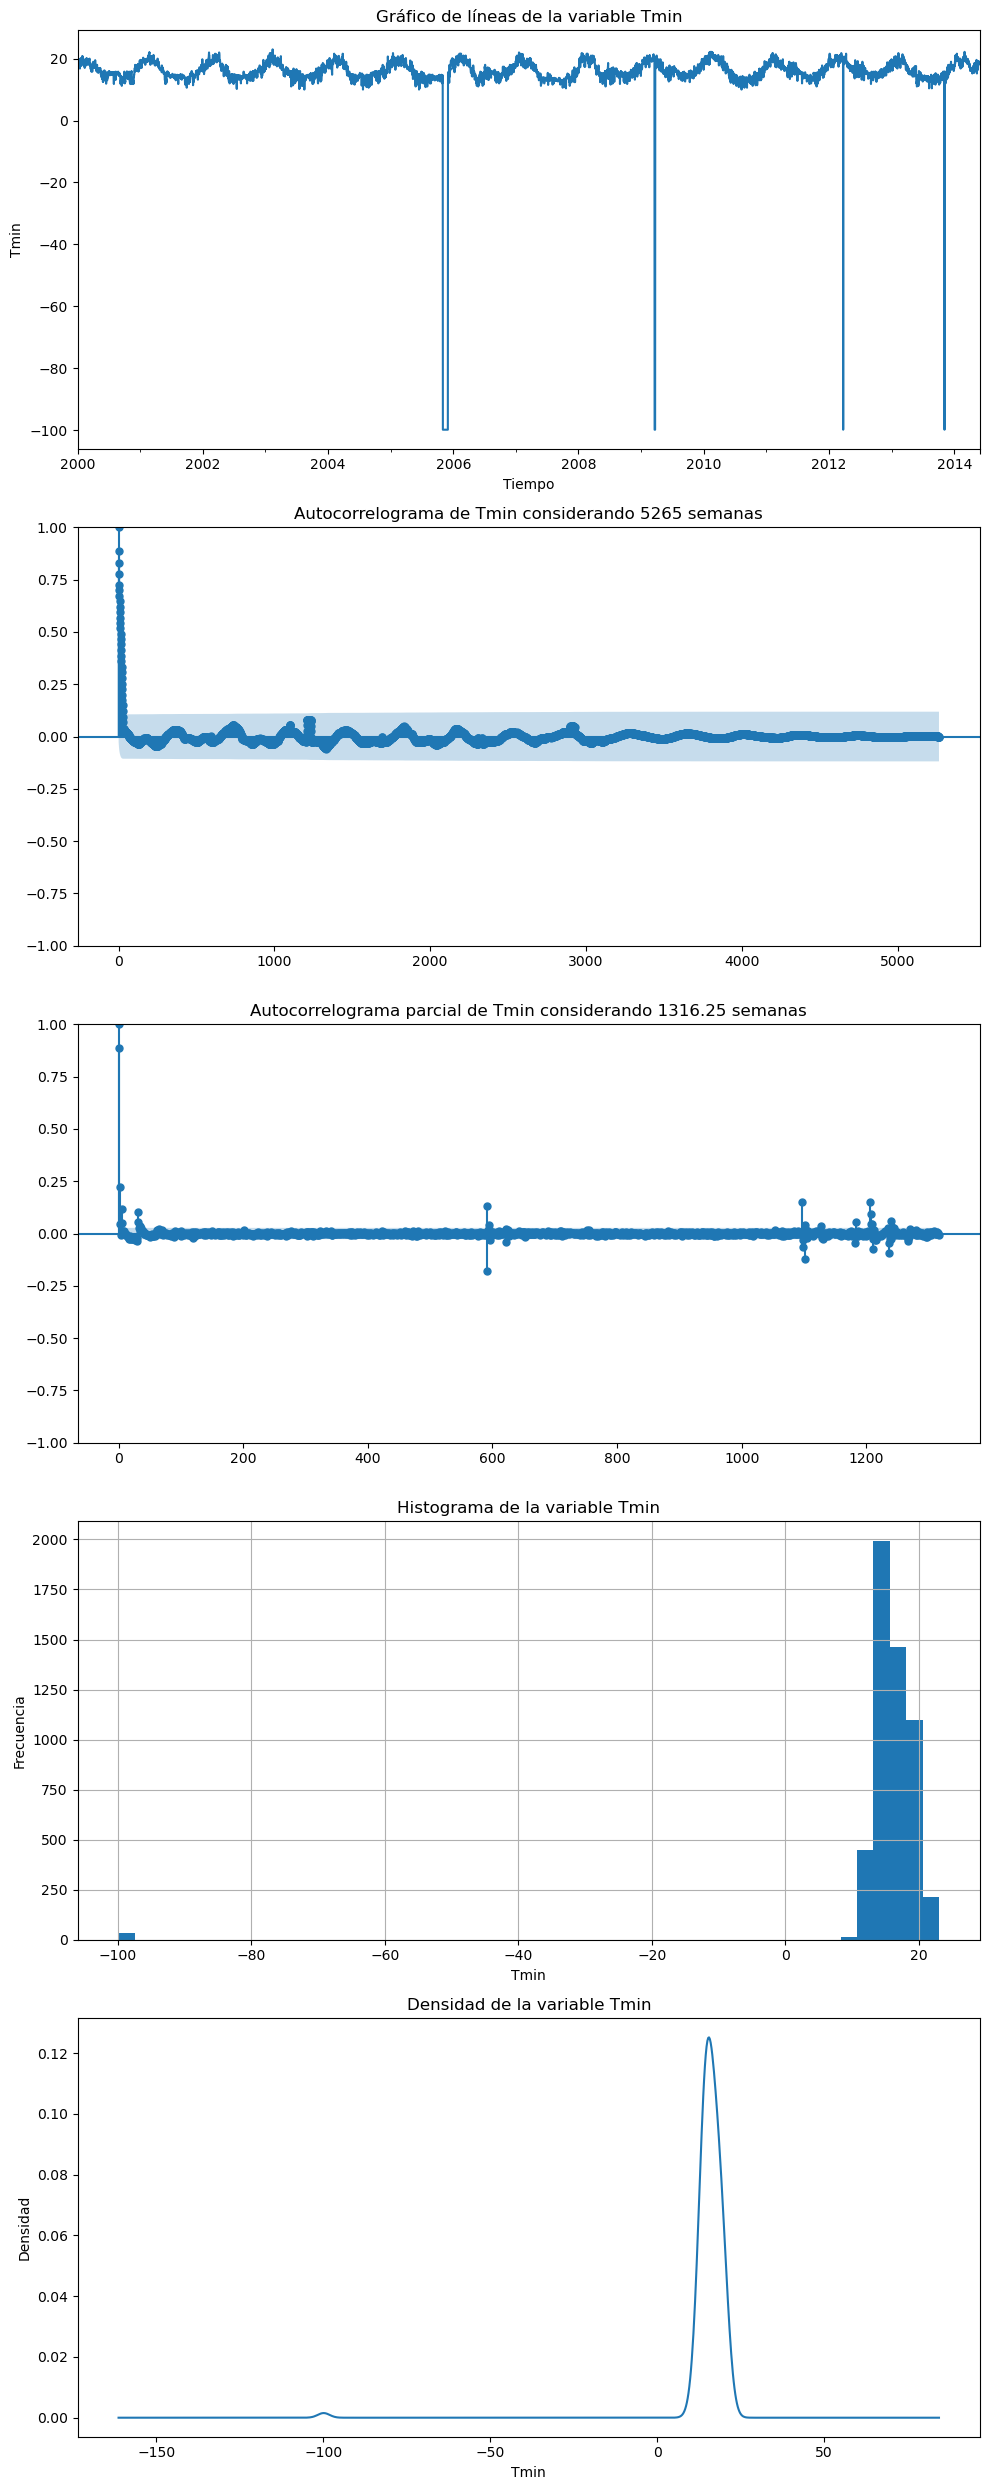

In [23]:
analizar_series_completo(Tmin,"Tmin")

In [24]:
Tmin.describe()

count    5265.000000
mean       15.410579
std         9.871707
min       -99.900000
25%        14.200000
50%        15.800000
75%        18.000000
max        23.000000
Name: Tmin, dtype: float64

In [25]:
Tmin[Tmin<0].value_counts()

Tmin
-99.9    36
Name: count, dtype: int64

En la serie Tmin se cuentan con 36 valores negativos. Se interpolarán linealmente esos valores.

In [26]:
Tmin = Tmin.apply(lambda x: np.nan if x < 0 else x) # Los valores negativos se ponen como NaN

In [27]:
Tmin[Tmin<0].value_counts() # Ya no se observan los valores negativos

Series([], Name: count, dtype: int64)

In [28]:
Tmin.describe() # Se observa que antes se tenían 5265 valores, ahora 5229

count    5229.000000
mean       16.204456
std         2.435445
min        10.000000
25%        14.300000
50%        15.800000
75%        18.100000
max        23.000000
Name: Tmin, dtype: float64

In [29]:
Tmin = Tmin.interpolate(method="linear")

In [30]:
Tmin.describe() # Se volvieron a añadir los 36 valores

count    5265.000000
mean       16.199544
std         2.433193
min        10.000000
25%        14.300000
50%        15.800000
75%        18.000000
max        23.000000
Name: Tmin, dtype: float64

Text(0.5, 1.0, 'Serie Tmin con valores negativos eliminados')

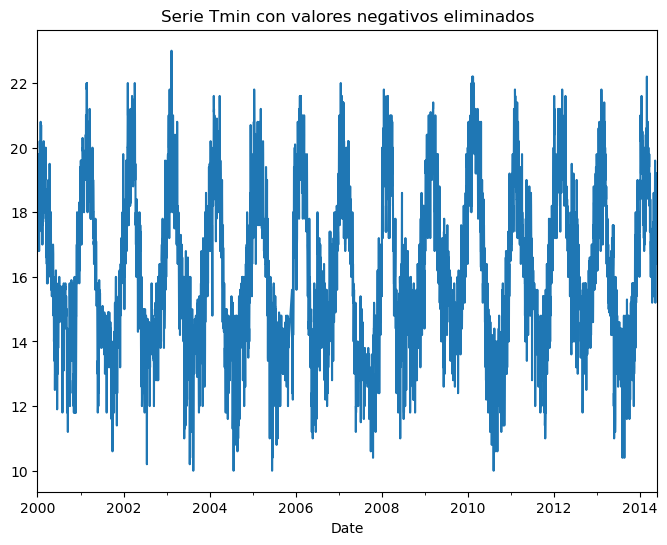

In [31]:
Tmin.plot()
plt.title("Serie Tmin con valores negativos eliminados")

## Modelos de Persistencia - Walk Forward

**Modelo de Persistencia last_value** : Los valores de Tmax de los siguientes 5 días son iguales al último valor observado de Tmax.

Función

In [27]:
# Modelo de persistencia de ultimo valor para forecasting multistep univariado con steps_out
def lastvalue_persistence(history, steps_out):
    # obtiene data del último día
    last_value = history[-1]
    # el forecast es una lista de steps_out valores iguales al ultimo valor de history
    forecast = [last_value for _ in range(steps_out)]
    return forecast

**Modelo de Persistencia mean_value**: Los valores de Tmax de los siguientes 5 días son iguales al promedio de los últimos 5 valores de Tmax.

Función

In [28]:
# Modelo de persistencia del valor promedio para forecasting multistep univariado con steps_out
def meanvalue_persistence(history, steps_out):
    # Obtiene el promedio de los útimos steps_out valores de la serie
    mean_value = sum(history[-steps_out:]) / len(history[-steps_out:])
    # El forecast es una lista de steps_out valores iguales al promedio de los últimos steps_out valores
    forecast = [mean_value for _ in range(steps_out)]
    return forecast

Función para evaluar las predicciones

In [29]:
# Evalua RMSE de predicciones de forecasting multistep con respecto a valores reales.
# 'predicted' es un numpy array con cada fila siendo una prediccion forecast multistep. Cada columna es un timestep adelante
# 'real' es un numpy array con cada fila i siendo los valores futuros verdaderos para comparar con la fila i de 'forecast'
def evaluate_forecasts(real, predicted):
    scores = list()
    # Para cada timestep t ahead calcula el RMSE
    for t in range(real.shape[1]):
        # calcula rmse
        rmse = sqrt( mean_squared_error(real[:, t], predicted[:, t]))
        # guarda rmse de esta hora
        scores.append(rmse)

    # calcula RMSE general
    s = 0
    for row in range(real.shape[0]):  # por cada vector pronosticado
        for col in range(real.shape[1]): # por cada time step
            s += (real[row, col] - predicted[row, col])**2
    score = sqrt(s / (real.shape[0] * real.shape[1]))
    return score, scores

Función para evaluar modelos en Walk-Forward

In [30]:
# evalua en walk-forward un modelo de forecasting multistep pasado (model_func) en su capacidad de predecir steps_out futuros,
# se le pasa la serie completa y la cantidad de los ultimos time_points que se usaran para test (test_size)
def evaluate_model(model_func, serie, test_size, steps_out):
    # split la serie en train - test
    train_serie, test_serie = serie[0:-test_size], serie[-test_size:]

    # validacion walk-forward de modelo de persistencia
    history = train_serie.tolist()  # serie historica para el modelado. Inicialmente es train

    # walk-forward validation sobre cada semana
    predictions = list()  # array donde se almacenan los vectores de prediccion multistep
    real = list()  # array donde se almacenan los vectores reales para comparar con las predicciones multistep
    for i in range(len(test_serie)-steps_out+1): # recorre cada time step de test
        # predice steps_out valores. model_func  se encarga de entrenar y hacer la prediccion
        yhat_sequence = model_func(history, steps_out)
        # almacena la secuencia predicha
        predictions.append(yhat_sequence)

        # adiciona al array real la secuencia que debio salir
        real.append(test_serie[i:i+steps_out])

        # añade la observacion real a history para la siguiente iteracion
        history.append(test_serie[i])
    predictions = np.array(predictions)
    real = np.array(real)
    # evalua las secuencias predichas en test (prediccion de OT) con respecto a lo que debio salir
    score, scores = evaluate_forecasts(real, predictions)
    return score, scores

Evaluación de modelos de Persistencia en Walk-Forward

**Modelos de Persistencia Last Value y Mean Value**

RMSE para Last value de Tmax: 1.976 
RMSE para Mean value de Tmax: 1.603 


C:\Users\rober\AppData\Local\Temp\ipykernel_11048\1278767904.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test_serie[i])
C:\Users\rober\AppData\Local\Temp\ipykernel_11048\1278767904.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test_serie[i])


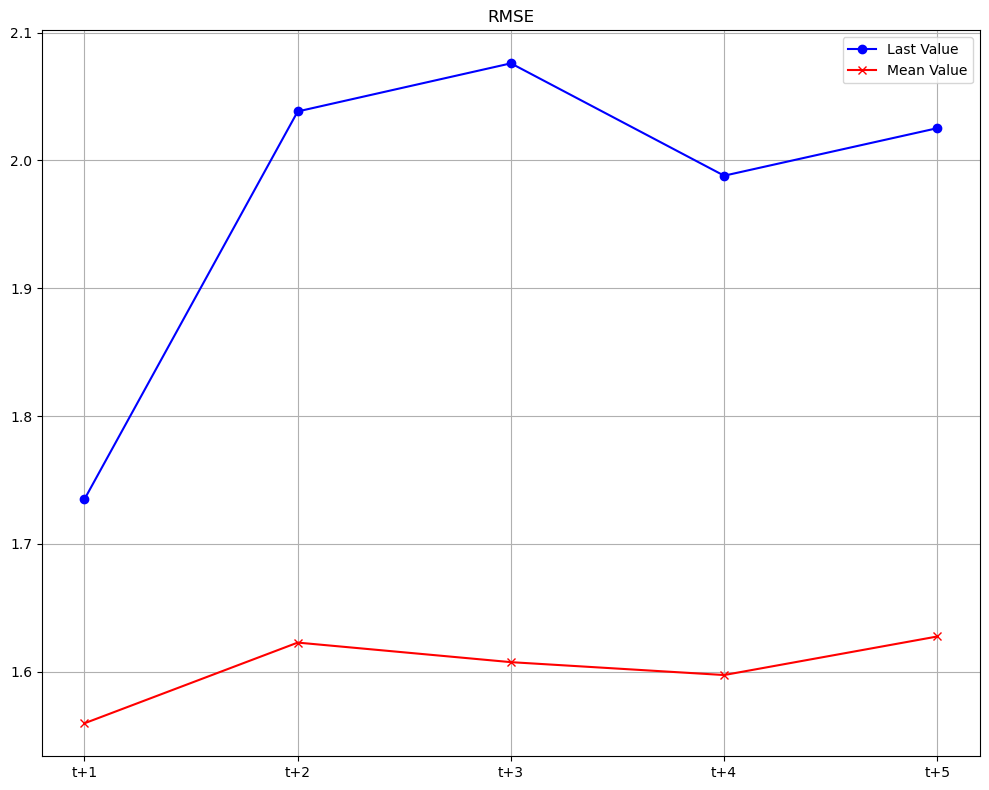

In [31]:
# Timesteps
time_labels = ["t+1", "t+2", "t+3", "t+4", "t+5"]

# Se evaluarán el 10% final de la serie Tmax
test_size = int(0.1* len(Tmax)) 

# Se configura el modelo para predecir 5 pasos hacia adelante.

steps_out = 5  # los modelos predicen 5 puntos temporales futuros

# Evaluación de modelo last_value
score_l, scores_l = evaluate_model(lastvalue_persistence, Tmax, test_size, steps_out)
# imprime score global last_value
print('RMSE para Last value de %s: %.3f ' % ("Tmax", score_l))

# Evaluación de modelo mean_value
score_m, scores_m = evaluate_model(meanvalue_persistence, Tmax, test_size, steps_out)
# imprime score global mean_value
print('RMSE para Mean value de %s: %.3f ' % ("Tmax", score_m))

# plot de scores
plt.figure(figsize=(10,8)) 
plt.plot(time_labels, scores_l, marker='o', color = "blue", label="Last Value")
plt.plot(time_labels, scores_m, marker="x", color="red", label="Mean Value")
plt.title("RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()

Se observa que el modelo de persistencia del tipo mean_value presenta un menor RMSE que el modelo last_value, por lo tanto, es más conveniente utilizar ese modelo para realizar predicciones básicas de persistencia.

Los modelos neuronales que serán entrenados deben presentar un menor RMSE que los presentados por estos modelos de persistencia.

## Modelos univariados

### Modelo neuronal LSTM 

Es evaluado un modelo de forecasting univariado multistep de tipo LSTM. Este tiene la capacidad de predecir los siguientes *n_steps_out* valores en base a los ultimos *n_steps_in* valores previos. 

Para comparar con los resultados de los modelos de persistencia se usa el 10% final de la serie **Tmax**.

In [58]:
# Librerías
from keras.models import Sequential
from keras.layers import Dense

from keras.models import Model
from keras.layers import Input

from sklearn.metrics import mean_squared_error   # para calcular el error cuadratico medio
from math import sqrt

from keras.layers import LSTM

#### Función para generar muestras de entrenamiento para forecasting univariado multistep

La funcion **split_sequence()** genera tuplas de secuencias de entrenamiento a partir de una serie univariada pasada. Esta desliza una ventana de *n_step_in* puntos temporales de ancho sobre la serie dada (sequence), generando las secuencias de entrada (inputs de la red) junto con la secuencia target que son los siguientes *n_steps_out* puntos de la misma secuencia.

In [59]:
# Funcion para generar secuencias de n_steps (rolling window) a partir de una secuencia univariada
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # calcula el indice del final de la secuencia
        end_ix = i + n_steps_in  # final de la muestra de entra
        out_end_ix = end_ix + n_steps_out  # final de la muestra de salida

        # si el indice es mayor que la secuencia entonces deja de generar mas muestras
        if out_end_ix > len(sequence):
            break

        X.append( sequence[i:end_ix] ) # añade la secuencia a la lista de muestras de entrada para entrenamiento
        y.append( sequence[end_ix:out_end_ix] )   # añade los siguientes  n_steps_out puntos como target
    return np.array(X), np.array(y)

Probamos la funcion split_sequence() sobre la serie Tmax

In [60]:
steps_in = 5
steps_out = 5

# genera las muestras de entrenamiento en rolling window a partir de la serie de entrenamiento
X, y = split_sequence(Tmax.values, steps_in, steps_out)
print (X.shape)

# muestra 5 ejemplos de la data
for i in range(5):
    print(X[i], y[i])

(5256, 5)
[26.6 27.  26.7 26.8 27. ] [27.8 28.  26.8 25.4 23.6]
[27.  26.7 26.8 27.  27.8] [28.  26.8 25.4 23.6 27.2]
[26.7 26.8 27.  27.8 28. ] [26.8 25.4 23.6 27.2 26.6]
[26.8 27.  27.8 28.  26.8] [25.4 23.6 27.2 26.6 26.4]
[27.  27.8 28.  26.8 25.4] [23.6 27.2 26.6 26.4 27.5]


#### Funciones para entrenamiento y prediccion de un modelo LSTM para forecasting univariado multistep

Se muestra una función para definir y entrenar un modelo LSTM de pronóstico univariado multi-step. Los hiperparámetros del modelo son pasados en el argumento *'config'* y son: 

* cantidad de timesteps de entrada
* cantidad de timesteps de forecast
* dimesión del estado oculto de la capa LSTM (lstm_units)
* el número de epocas de entrenamiento y
* el tamaño del minibatch de entrenamiento

In [61]:
# Funcion para entrenar el modelo LSTM para forecasting univariado multistep
def univar_multistep_lstm_fit(train_serie, config):
    # desempaca los hiperparámetros de configuración de modelo
    steps_in, steps_out, lstm_units, n_epochs, n_batch = config

    # genera las muestras de entrenamiento en rolling window a partir de la serie pasada
    X, y = split_sequence(train_serie, steps_in, steps_out)

    # Para entrenar CNN tenemos que hacer reshape de X de [samples, timesteps] a [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], 1))

    ## define arquitectura de modelo LSTM
    modelo = Sequential()
    # capa lstm con dimension lstm_units  y secuencias de entrada unidimensionales de n_steps_in pasos
    modelo.add(LSTM(lstm_units, activation='relu', input_shape=(steps_in, 1)))
    # capa densa de 20 unidades
    modelo.add(Dense(20, activation='relu'))
    # capa de salida
    modelo.add(Dense(steps_out))
    modelo.compile(loss='mse', optimizer='adam')

    # entrena el modelo con la data de entrenamiento generada
    modelo.fit(X, y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return modelo

La función **univar_multistep_lstm_predict** realiza el forecasting con un modelo LSTM ya ajustado y en base a la serie histórica

In [62]:
# predice n_steps_out valores siguientes de la serie history con un modelo LSTM ya ajustado
def univar_multistep_lstm_predict(modelo, history_serie, config):
    # desempaca los hiperparámetros de configuración de modelo
    steps_in, steps_out, lstm_units, n_epochs, n_batch = config

    # prepara la muestra de entrada al modelo para hacer la prediccion
    # tiene que estar en el shape [samples, timesteps, numfeatures],  timesteps = los ultimos steps_in puntos temporales
    X_input = np.array(history_serie[-steps_in:]).reshape(1, steps_in, 1)

    # predice
    yhat = modelo.predict(X_input, verbose=0)
    return yhat[0]

#### Función para evaluar en walk-forward un modelo LSTM para forecasting univariado multistep

In [63]:
# evalua el modelo LSTM univariado multi-step en walk-forward
def evaluate_univar_multistep_lstm(serie, test_size, config):
    # desempaca los hiperparámetros de configuración de modelo
    steps_in, steps_out, lstm_units, n_epochs, n_batch = config

    # split la serie en train - test
    train_serie, test_serie = serie[0:-test_size], serie[-test_size:]

    # Entrena un modelo CNN para evaluar en walk-forward (solo se entrena una vez)
    modelo = univar_multistep_lstm_fit(train_serie, config)

    # Inicializa la serie historica con la serie de training para empezar la evaluacion en walk-forward
    history = train_serie.tolist()

    # walk-forward validation sobre cada semana
    predictions = list()  # array donde se almacenan los vectores de prediccion multistep
    real = list()  # array donde se almacenan los vectores reales para comparar con las predicciones multistep
    for i in range(len(test_serie)-steps_out+1): # recorre cada time step de test
        # predice  con el modelo
        yhat_sequence = univar_multistep_lstm_predict(modelo, history, config)
        # almacena la secuencia predicha
        predictions.append(yhat_sequence)
        # adiciona al array real la secuencia que debió salir
        real.append(test_serie[i:i+steps_out])
        # añade la observacion real a history para la siguiente iteracion
        history.append(test_serie[i])
    predictions = np.array(predictions)
    real = np.array(real)
    # evalua las secuencias predichas en test (prediccion de Global_active_power) con respecto a lo que debio salir
    score, scores = evaluate_forecasts(real, predictions)
    return score, scores

#### Evalua la calidad de pronostico (5 dias) de modelo LSTM univariado multistep sobre la serie 'Tmax'

##### Configuración 0 (base): steps_in = 5, lstms_units = 20

* steps_in = 5
* steps_out = 5
* lstms_units = 20
* n_epochs = 500
* n_batch = 32

C:\Users\rober\anaconda3\envs\env_robert_series\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE de univar_multistep_lstm: 1.601 


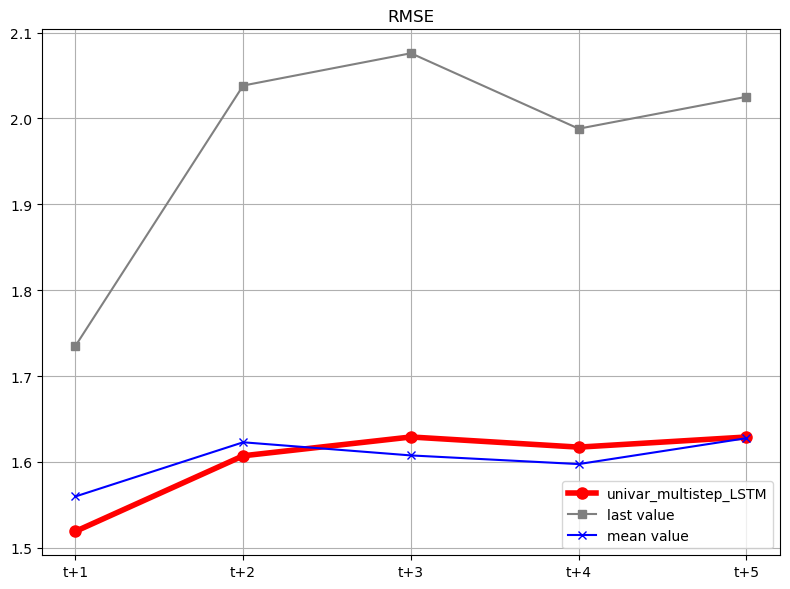

In [65]:
time_labels = ['t+1', 't+2', 't+3', 't+4', 't+5']  # etiquetas de tiempo para ploteo de las metricas RMSE

test_size = int(0.1* len(Tmax)) # Se evaluará el 10% final de la serie Tmax

steps_in = 5  # con cuantos puntos temporales previos se va hacer el forecasting

steps_out = 5  # los modelos predicen 5 puntos temporales futuros

lstm_units = 20   # dimension de la capa lstm

n_epochs = 500   # numero de epocas de entrenamiento

n_batch  = 32    # tamaño del minibatch de entrenamiento

# Define la configuración del modelo LSTM:  [steps_in, steps_out, lstm_units, n_epochs, n_batch]
config = [steps_in, steps_out, lstm_units, n_epochs, n_batch]

# Evalua el modelo LSTM univariado multi-step  en walk-forward
score, scores = evaluate_univar_multistep_lstm(Tmax.values, test_size, config)

# Imprime score
print('RMSE de univar_multistep_lstm: %.3f ' % (score))

# Plotea scores
plt.figure(figsize=(8,6))
plt.plot(time_labels, scores, marker='o', color = "red", label='univar_multistep_LSTM', linewidth=4, markersize=8)
plt.plot(time_labels, scores_l, marker='s', color = "gray", label="last value")
plt.plot(time_labels, scores_m, marker="x", color="blue", label="mean value")
plt.title("RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()

# Guardamos los resultados
resultados = []
config.append(score)
config = config + scores
resultados.append(config)

#### Optimización de Hiperparámetros

Se realizará la busqueda en grilla con los siguientes parámetros:

* steps_in = [5, 10, 15]
* lstm_units = [20, 50, 100]

##### Configuración 1: steps_in = 10, lstms_units = 20

C:\Users\rober\anaconda3\envs\env_robert_series\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE de univar_multistep_lstm: 1.561 


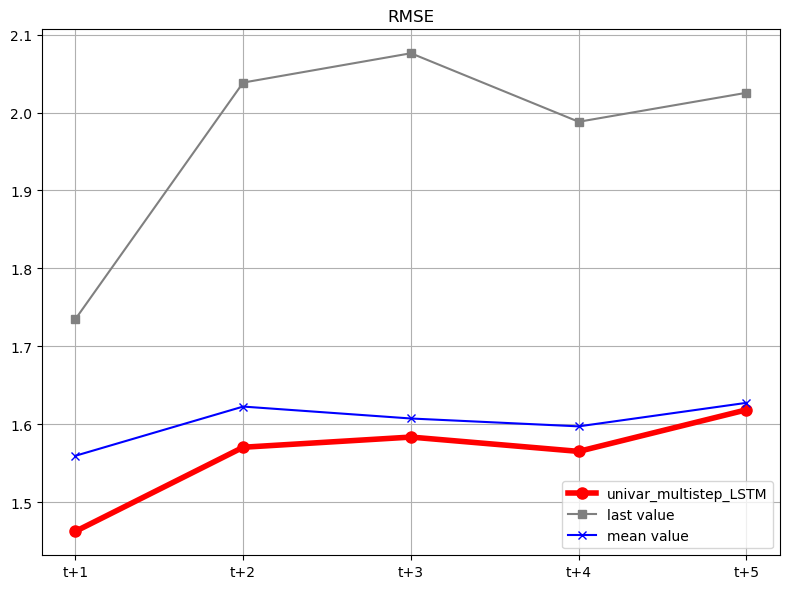

In [66]:
time_labels = ['t+1', 't+2', 't+3', 't+4', 't+5']  # etiquetas de tiempo para ploteo de las metricas RMSE

test_size = int(0.1* len(Tmax)) # Se evaluará el 10% final de la serie Tmax

steps_in = 10  # con cuantos puntos temporales previos se va hacer el forecasting

steps_out = 5  # los modelos predicen 7 puntos temporales futuros

lstm_units = 20   # dimension de la capa lstm

n_epochs = 500   # numero de epocas de entrenamiento

n_batch  = 32    # tamaño del minibatch de entrenamiento

# Define la configuración del modelo LSTM:  [steps_in, steps_out, lstm_units, n_epochs, n_batch]
config = [steps_in, steps_out, lstm_units, n_epochs, n_batch]

# Evalua el modelo LSTM univariado multi-step  en walk-forward
score, scores = evaluate_univar_multistep_lstm(Tmax.values, test_size, config)

# Imprime score
print('RMSE de univar_multistep_lstm: %.3f ' % (score))

# Plotea scores
plt.figure(figsize=(8,6))
plt.plot(time_labels, scores, marker='o', color = "red", label='univar_multistep_LSTM', linewidth=4, markersize=8)
plt.plot(time_labels, scores_l, marker='s', color = "gray", label="last value")
plt.plot(time_labels, scores_m, marker="x", color="blue", label="mean value")
plt.title("RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()

# Guardamos los resultados
config.append(score)
config = config + scores
resultados.append(config)

##### Configuración 2: steps_in = 15, lstm_units = 20

C:\Users\rober\anaconda3\envs\env_robert_series\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE de univar_multistep_lstm: 1.574 


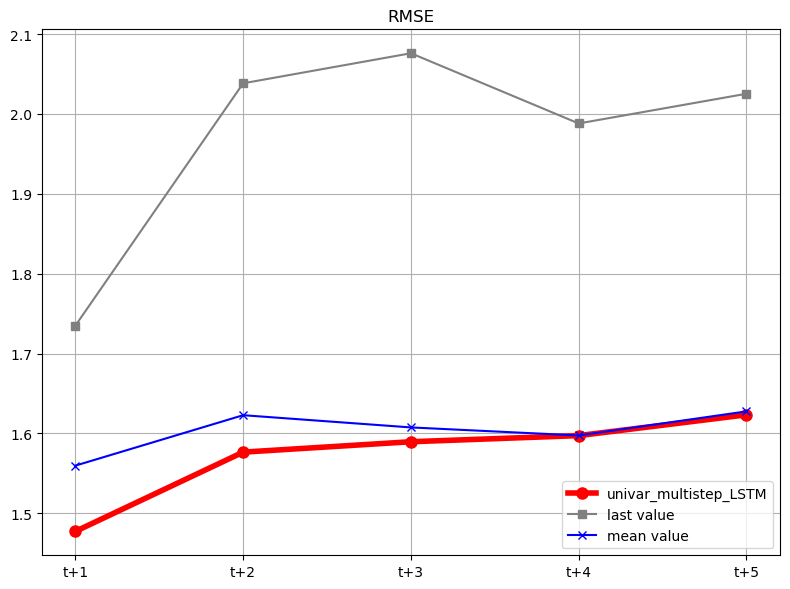

In [67]:
time_labels = ['t+1', 't+2', 't+3', 't+4', 't+5']  # etiquetas de tiempo para ploteo de las metricas RMSE

test_size = int(0.1* len(Tmax)) # Se evaluará el 10% final de la serie Tmax

steps_in = 15  # con cuantos puntos temporales previos se va hacer el forecasting

steps_out = 5  # los modelos predicen 7 puntos temporales futuros

lstm_units = 20   # dimension de la capa lstm

n_epochs = 500   # numero de epocas de entrenamiento

n_batch  = 32    # tamaño del minibatch de entrenamiento

# Define la configuración del modelo LSTM:  [steps_in, steps_out, lstm_units, n_epochs, n_batch]
config = [steps_in, steps_out, lstm_units, n_epochs, n_batch]

# Evalua el modelo LSTM univariado multi-step  en walk-forward
score, scores = evaluate_univar_multistep_lstm(Tmax.values, test_size, config)

# Imprime score
print('RMSE de univar_multistep_lstm: %.3f ' % (score))

# Plotea scores
plt.figure(figsize=(8,6))
plt.plot(time_labels, scores, marker='o', color = "red", label='univar_multistep_LSTM', linewidth=4, markersize=8)
plt.plot(time_labels, scores_l, marker='s', color = "gray", label="last value")
plt.plot(time_labels, scores_m, marker="x", color="blue", label="mean value")
plt.title("RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()

# Guardamos los resultados
config.append(score)
config = config + scores
resultados.append(config)

##### Configuración 3: steps_in = 5, lstm_units = 50

C:\Users\rober\anaconda3\envs\env_robert_series\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE de univar_multistep_lstm: 1.600 


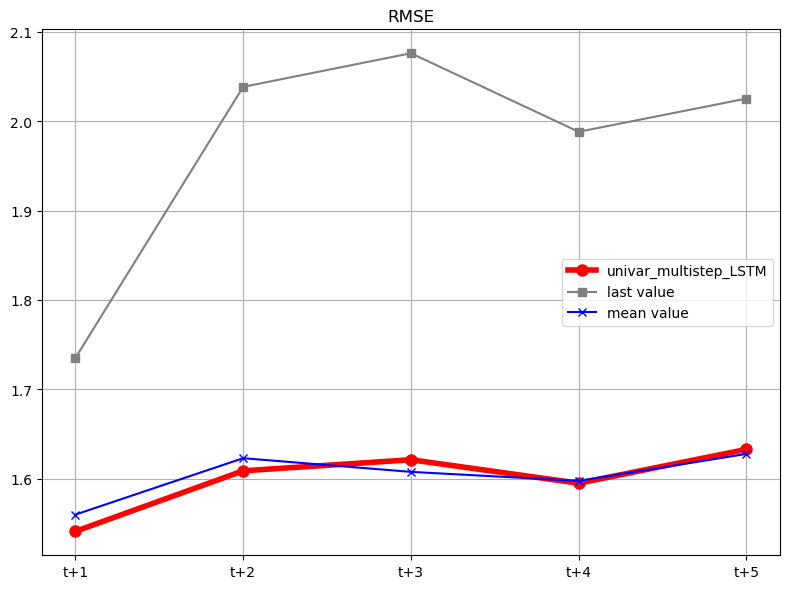

In [68]:
time_labels = ['t+1', 't+2', 't+3', 't+4', 't+5']  # etiquetas de tiempo para ploteo de las metricas RMSE

test_size = int(0.1* len(Tmax)) # Se evaluará el 10% final de la serie Tmax

steps_in = 5  # con cuantos puntos temporales previos se va hacer el forecasting

steps_out = 5  # los modelos predicen 7 puntos temporales futuros

lstm_units = 50   # dimension de la capa lstm

n_epochs = 500   # numero de epocas de entrenamiento

n_batch  = 32    # tamaño del minibatch de entrenamiento

# Define la configuración del modelo LSTM:  [steps_in, steps_out, lstm_units, n_epochs, n_batch]
config = [steps_in, steps_out, lstm_units, n_epochs, n_batch]

# Evalua el modelo LSTM univariado multi-step  en walk-forward
score, scores = evaluate_univar_multistep_lstm(Tmax.values, test_size, config)

# Imprime score
print('RMSE de univar_multistep_lstm: %.3f ' % (score))

# Plotea scores
plt.figure(figsize=(8,6))
plt.plot(time_labels, scores, marker='o', color = "red", label='univar_multistep_LSTM', linewidth=4, markersize=8)
plt.plot(time_labels, scores_l, marker='s', color = "gray", label="last value")
plt.plot(time_labels, scores_m, marker="x", color="blue", label="mean value")
plt.title("RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()

# Guardamos los resultados
config.append(score)
config = config + scores
resultados.append(config)

##### Configuración 4: steps_in = 10, lstm_units = 50

C:\Users\rober\anaconda3\envs\env_robert_series\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE de univar_multistep_lstm: 1.563 


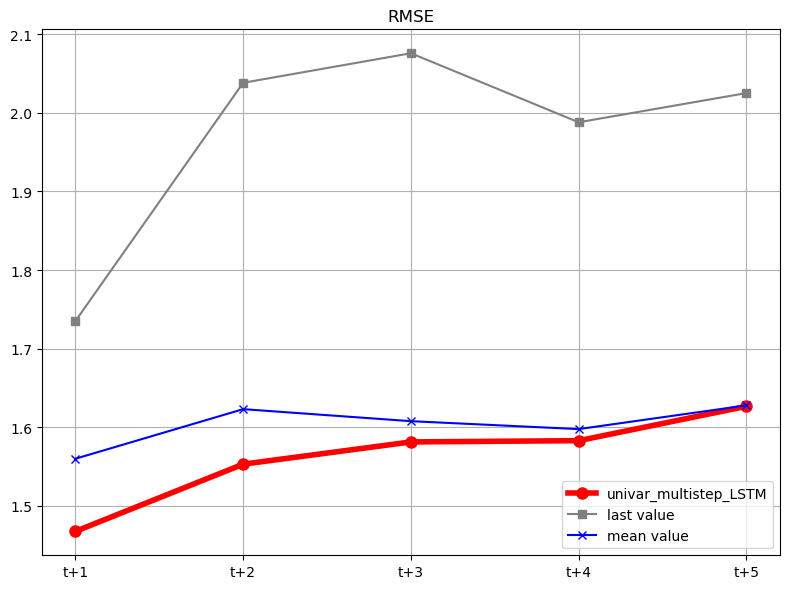

In [69]:
time_labels = ['t+1', 't+2', 't+3', 't+4', 't+5']  # etiquetas de tiempo para ploteo de las metricas RMSE

test_size = int(0.1* len(Tmax)) # Se evaluará el 10% final de la serie Tmax

steps_in = 10  # con cuantos puntos temporales previos se va hacer el forecasting

steps_out = 5  # los modelos predicen 7 puntos temporales futuros

lstm_units = 50   # dimension de la capa lstm

n_epochs = 500   # numero de epocas de entrenamiento

n_batch  = 32    # tamaño del minibatch de entrenamiento

# Define la configuración del modelo LSTM:  [steps_in, steps_out, lstm_units, n_epochs, n_batch]
config = [steps_in, steps_out, lstm_units, n_epochs, n_batch]

# Evalua el modelo LSTM univariado multi-step  en walk-forward
score, scores = evaluate_univar_multistep_lstm(Tmax.values, test_size, config)

# Imprime score
print('RMSE de univar_multistep_lstm: %.3f ' % (score))

# Plotea scores
plt.figure(figsize=(8,6))
plt.plot(time_labels, scores, marker='o', color = "red", label='univar_multistep_LSTM', linewidth=4, markersize=8)
plt.plot(time_labels, scores_l, marker='s', color = "gray", label="last value")
plt.plot(time_labels, scores_m, marker="x", color="blue", label="mean value")
plt.title("RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()

# Guardamos los resultados
config.append(score)
config = config + scores
resultados.append(config)

##### Configuración 5: steps_in = 15, lstm_units = 50

C:\Users\rober\anaconda3\envs\env_robert_series\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE de univar_multistep_lstm: 1.563 


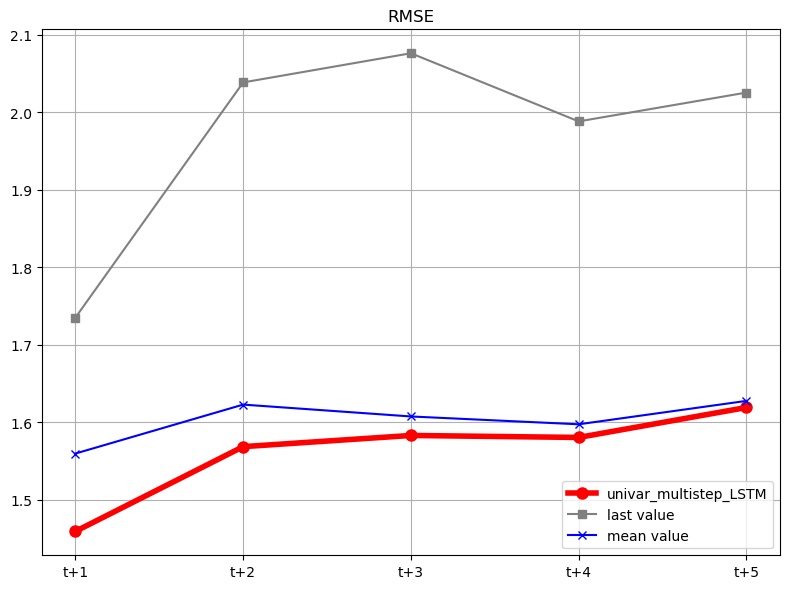

In [70]:
time_labels = ['t+1', 't+2', 't+3', 't+4', 't+5']  # etiquetas de tiempo para ploteo de las metricas RMSE

test_size = int(0.1* len(Tmax)) # Se evaluará el 10% final de la serie Tmax

steps_in = 15  # con cuantos puntos temporales previos se va hacer el forecasting

steps_out = 5  # los modelos predicen 7 puntos temporales futuros

lstm_units = 50   # dimension de la capa lstm

n_epochs = 500   # numero de epocas de entrenamiento

n_batch  = 32    # tamaño del minibatch de entrenamiento

# Define la configuración del modelo LSTM:  [steps_in, steps_out, lstm_units, n_epochs, n_batch]
config = [steps_in, steps_out, lstm_units, n_epochs, n_batch]

# Evalua el modelo LSTM univariado multi-step  en walk-forward
score, scores = evaluate_univar_multistep_lstm(Tmax.values, test_size, config)

# Imprime score
print('RMSE de univar_multistep_lstm: %.3f ' % (score))

# Plotea scores
plt.figure(figsize=(8,6))
plt.plot(time_labels, scores, marker='o', color = "red", label='univar_multistep_LSTM', linewidth=4, markersize=8)
plt.plot(time_labels, scores_l, marker='s', color = "gray", label="last value")
plt.plot(time_labels, scores_m, marker="x", color="blue", label="mean value")
plt.title("RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()

# Guardamos los resultados
config.append(score)
config = config + scores
resultados.append(config)

##### Configuración 6: steps_in = 5, lstm_units = 100

C:\Users\rober\anaconda3\envs\env_robert_series\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE de univar_multistep_lstm: 1.588 


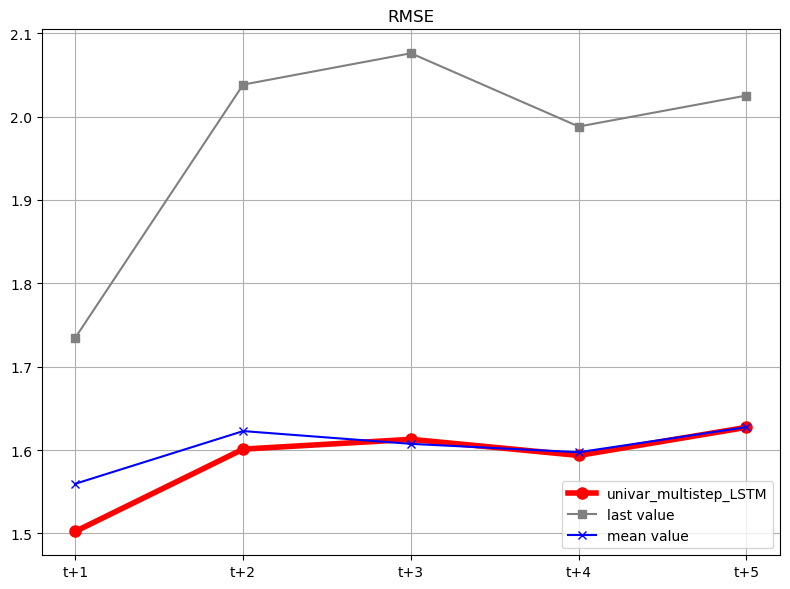

In [71]:
time_labels = ['t+1', 't+2', 't+3', 't+4', 't+5']  # etiquetas de tiempo para ploteo de las metricas RMSE

test_size = int(0.1* len(Tmax)) # Se evaluará el 10% final de la serie Tmax

steps_in = 5  # con cuantos puntos temporales previos se va hacer el forecasting

steps_out = 5  # los modelos predicen 7 puntos temporales futuros

lstm_units = 100   # dimension de la capa lstm

n_epochs = 500   # numero de epocas de entrenamiento

n_batch  = 32    # tamaño del minibatch de entrenamiento

# Define la configuración del modelo LSTM:  [steps_in, steps_out, lstm_units, n_epochs, n_batch]
config = [steps_in, steps_out, lstm_units, n_epochs, n_batch]

# Evalua el modelo LSTM univariado multi-step  en walk-forward
score, scores = evaluate_univar_multistep_lstm(Tmax.values, test_size, config)

# Imprime score
print('RMSE de univar_multistep_lstm: %.3f ' % (score))

# Plotea scores
plt.figure(figsize=(8,6))
plt.plot(time_labels, scores, marker='o', color = "red", label='univar_multistep_LSTM', linewidth=4, markersize=8)
plt.plot(time_labels, scores_l, marker='s', color = "gray", label="last value")
plt.plot(time_labels, scores_m, marker="x", color="blue", label="mean value")
plt.title("RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()

# Guardamos los resultados
config.append(score)
config = config + scores
resultados.append(config)

##### Configuración 7: steps_in = 10, lstm_units = 100

C:\Users\rober\anaconda3\envs\env_robert_series\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE de univar_multistep_lstm: 1.565 


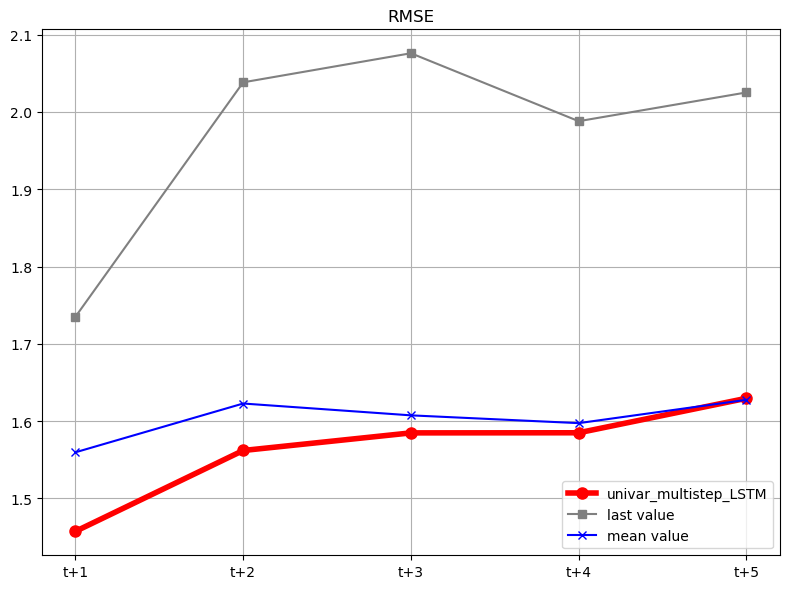

In [72]:
time_labels = ['t+1', 't+2', 't+3', 't+4', 't+5']  # etiquetas de tiempo para ploteo de las metricas RMSE

test_size = int(0.1* len(Tmax)) # Se evaluará el 10% final de la serie Tmax

steps_in = 10  # con cuantos puntos temporales previos se va hacer el forecasting

steps_out = 5  # los modelos predicen 7 puntos temporales futuros

lstm_units = 100   # dimension de la capa lstm

n_epochs = 500   # numero de epocas de entrenamiento

n_batch  = 32    # tamaño del minibatch de entrenamiento

# Define la configuración del modelo LSTM:  [steps_in, steps_out, lstm_units, n_epochs, n_batch]
config = [steps_in, steps_out, lstm_units, n_epochs, n_batch]

# Evalua el modelo LSTM univariado multi-step  en walk-forward
score, scores = evaluate_univar_multistep_lstm(Tmax.values, test_size, config)

# Imprime score
print('RMSE de univar_multistep_lstm: %.3f ' % (score))

# Plotea scores
plt.figure(figsize=(8,6))
plt.plot(time_labels, scores, marker='o', color = "red", label='univar_multistep_LSTM', linewidth=4, markersize=8)
plt.plot(time_labels, scores_l, marker='s', color = "gray", label="last value")
plt.plot(time_labels, scores_m, marker="x", color="blue", label="mean value")
plt.title("RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()

# Guardamos los resultados
config.append(score)
config = config + scores
resultados.append(config)

##### Configuración 8: steps_in = 15, lstm_units = 100

C:\Users\rober\anaconda3\envs\env_robert_series\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE de univar_multistep_lstm: 1.908 


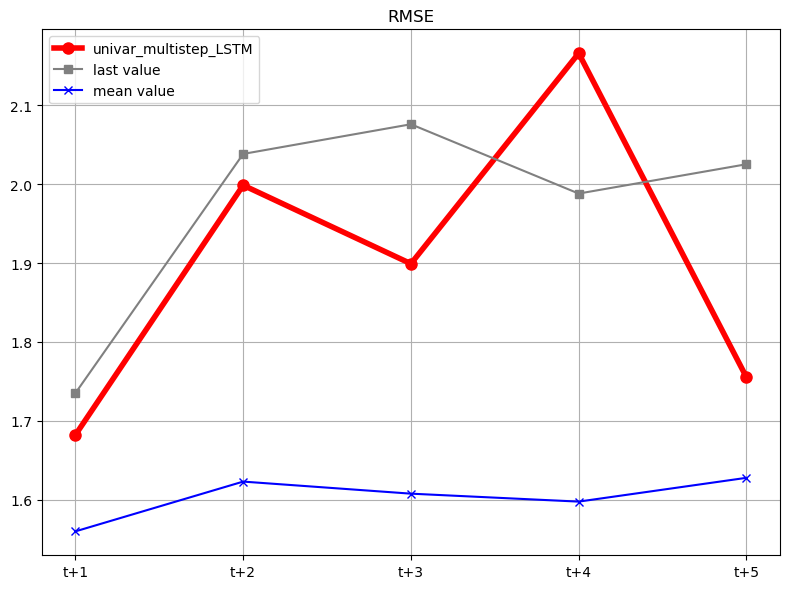

In [73]:
time_labels = ['t+1', 't+2', 't+3', 't+4', 't+5']  # etiquetas de tiempo para ploteo de las metricas RMSE

test_size = int(0.1* len(Tmax)) # Se evaluará el 10% final de la serie Tmax

steps_in = 15  # con cuantos puntos temporales previos se va hacer el forecasting

steps_out = 5  # los modelos predicen 7 puntos temporales futuros

lstm_units = 100   # dimension de la capa lstm

n_epochs = 500   # numero de epocas de entrenamiento

n_batch  = 32    # tamaño del minibatch de entrenamiento

# Define la configuración del modelo LSTM:  [steps_in, steps_out, lstm_units, n_epochs, n_batch]
config = [steps_in, steps_out, lstm_units, n_epochs, n_batch]

# Evalua el modelo LSTM univariado multi-step  en walk-forward
score, scores = evaluate_univar_multistep_lstm(Tmax.values, test_size, config)

# Imprime score
print('RMSE de univar_multistep_lstm: %.3f ' % (score))

# Plotea scores
plt.figure(figsize=(8,6))
plt.plot(time_labels, scores, marker='o', color = "red", label='univar_multistep_LSTM', linewidth=4, markersize=8)
plt.plot(time_labels, scores_l, marker='s', color = "gray", label="last value")
plt.plot(time_labels, scores_m, marker="x", color="blue", label="mean value")
plt.title("RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()

# Guardamos los resultados
config.append(score)
config = config + scores
resultados.append(config)

#### Resultados

In [74]:
columnas = ['steps_in', 'steps_out', 'lstm_units', 'n_epochs', 'n_batch', 'RMSE', 'RMSE t+1', 'RMSE t+2', 'RMSE t+3', 'RMSE t+4', 'RMSE t+5']
df = pd.DataFrame(data=resultados, columns=columnas)
df = df.sort_values(by='RMSE')
df

,steps_in,steps_out,lstm_units,n_epochs,n_batch,RMSE,RMSE t+1,RMSE t+2,RMSE t+3,RMSE t+4,RMSE t+5
1,10,5,20,500,32,1.561082,1.462743,1.570643,1.583688,1.565333,1.618647
4,10,5,50,500,32,1.562949,1.467206,1.552780,1.581102,1.582704,1.626466
5,15,5,50,500,32,1.563038,1.459313,1.568595,1.583029,1.580457,1.619113
7,10,5,100,500,32,1.564830,1.457409,1.562051,1.584833,1.584978,1.629590
2,15,5,20,500,32,1.573630,1.477378,1.576591,1.589601,1.597278,1.623311
6,5,5,100,500,32,1.588135,1.502540,1.601201,1.612926,1.593619,1.627342
3,5,5,50,500,32,1.599961,1.540931,1.608693,1.621083,1.594812,1.632691
0,5,5,20,500,32,1.600795,1.519051,1.607110,1.628995,1.617172,1.628965
8,15,5,100,500,32,1.908024,1.681974,1.998662,1.899138,2.166076,1.755133


Según los resultados, el mejor modelo se obtiene con **steps_in=10** y **lstm_units=20**, dando un RMSE=1.561 (vs RMSE=1.603 del modelo de persistencia mean value). Ver gráfico de la Configuración 5.

### CNN

Se utilizará un modelo CNN para hacer un análisis univariado multistep de la variable Tmax. Además, se realizará una búsqueda por grilla para buscar los hiperparámetros más óptimos.

Librerías

In [38]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force TF to use only the CPU
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')  # obtiene las gpus instaladas
if len(gpus) > 0:   # si hay alguna gpu instalada
    # setea para usar solo la memória de la GPU necesária en tiempo de ejecucion
    tf.config.experimental.set_memory_growth(gpus[0], True)
print(gpus)

[]


In [37]:
import pandas as pd
import numpy as np
from numpy import hstack
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate

from sklearn.metrics import mean_squared_error   # para calcular el error cuadratico medio
from math import sqrt

Función para generar secuencias de step_in de entrada y steps_out de target a partir de una secuencia univariada.

In [32]:
def split_sequence(sequence, steps_in, steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # calcula el indice del final de la secuencia
        end_ix = i + steps_in  # final de la muestra de entra
        out_end_ix = end_ix + steps_out  # final de la muestra de salida

        # si el indice es mayor que la secuencia entonces deja de generar mas muestras
        if out_end_ix > len(sequence)-1:
            break

        X.append( sequence[i:end_ix] ) # añade la secuencia a la lista de muestras de entrada para entrenamiento
        y.append( sequence[end_ix:out_end_ix] )   # añade los siguientes  steps_out puntos como target
    return np.array(X), np.array(y)

Funciones para entrenamiento y prediccion de un modelo CNN para forecasting univariado multistep

In [33]:
# Funcion para entrenar el modelo CNN para forecasting univariado multistep
def univar_multistep_cnn_fit(train_serie, config):
    # desempaca los hiperparámetros de configuración de modelo
    steps_in, steps_out, n_filters, n_kernel, n_epochs, n_batch = config

    # genera las muestras de entrenamiento en rolling window a partir de la serie pasada
    X, y = split_sequence(train_serie, steps_in, steps_out)

    # Para entrenar CNN tenemos que hacer reshape de X de [samples, timesteps] a [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # define arquitectura de modelo MLP
    modelo = Sequential()
    modelo.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(steps_in, 1)))
    modelo.add(MaxPooling1D(pool_size=2))  # pooling layer con pool_size = 2
    modelo.add(Flatten())
    modelo.add(Dense(50, activation='relu'))  # 50 neurones de la capa densa
    modelo.add(Dense(steps_out))
    modelo.compile(loss='mse', optimizer='adam')

    # entrena el modelo con la la data de entrenamiento generada
    modelo.fit(X, y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return modelo

La funcion <b>univar_multistep_cnn_predict</b> hace el forecasting con un modelo CNN ya ajustado y en base a la serie histórica

In [34]:
# predice steps_out valores siguientes de la serie history con un modelo CNN ya ajustado
def univar_multistep_cnn_predict(modelo, history_serie, config):
    # desempaca los hiperparámetros de configuración de modelo
    steps_in, steps_out, n_filters, n_kernel, n_epochs, n_batch = config

    # prepara la muestra a ingresar al modelo para hacer la prediccion (los ultimos n_steps_in puntos temporales)
    X_input = np.array(history_serie[-steps_in:]).reshape(1, steps_in, 1)

    # predice
    yhat = modelo.predict(X_input, verbose=0)
    return yhat[0]

Funcion para evaluar en walk-forward un modelo CNN para forecasting univariado multistep

In [35]:
# evalua el modelo CNN univariado multi-step  en walk-forward
def evaluate_univar_multistep_cnn(serie, test_size, config):
    # desempaca los hiperparámetros de configuración de modelo
    steps_in, steps_out, n_filters, n_kernel, n_epochs, n_batch = config

    # split la serie en train - test
    train_serie, test_serie = serie[0:-test_size], serie[-test_size:]

    # Entrena un modelo CNN para evaluar en walk-forward (solo se entrena una vez)
    modelo = univar_multistep_cnn_fit(train_serie, config)

    # Inicializa la serie historica con la serie de training para empezar la evaluacion en walk-forward
    history = train_serie.tolist()

    # walk-forward validation sobre cada semana
    predictions = list()  # array donde se almacenan los vectores de prediccion multistep
    real = list()  # array donde se almacenan los vectores reales para comparar con las predicciones multistep
    for i in range(len(test_serie)-steps_out+1): # recorre cada time step de test
        # predice  con el modelo
        yhat_sequence = univar_multistep_cnn_predict(modelo, history, config)
        # almacena la secuencia predicha
        predictions.append(yhat_sequence)
        # adiciona al array real la secuencia que debió salir
        real.append(test_serie[i:i+steps_out])
        # añade la observacion real a history para la siguiente iteracion
        history.append(test_serie[i])
    predictions = np.array(predictions)
    real = np.array(real)
    # evalua las secuencias predichas en test (prediccion de Global_active_power) con respecto a lo que debio salir
    score, scores = evaluate_forecasts(real, predictions)
    return score, scores

**Búsqueda por grilla para encontrar los mejores hiperparámetros**

In [43]:
time_labels = ['t+1', 't+2', 't+3', 't+4', 't+5']  # etiquetas de tiempo para ploteo de las metricas RMSE
test_size = int(0.1* len(Tmax))   # se realiza el test en el 10% final de los datos
steps_in = 10  # con cuantos puntos temporales previos  se va hacer el forecasting
steps_out = 5  # los modelos predicen 5 puntos temporales futuros
n_filter = [30, 50, 70, 100] # numero de filtros convulacionales
n_kernel = [3, 4, 5]    # tamaño del nerkel
n_epochs = 500   # numero de epocas de entrenamiento
n_batch  = 32    # tamaño del minibatch de entrenamiento

# búsqueda por grilla de mejores hiperparámetros
best_score = float("inf")
best_params = None

for n in n_filter:
    for j in n_kernel:
    # Nueva configuración
        config = [steps_in, steps_out, n, j, n_epochs, n_batch]
        # Se calcucan los scores
        score, scores = evaluate_univar_multistep_cnn(Tmax.values, test_size, config)
        # Comparación de mejores hiperparámetros
        if score < best_score:
            best_score = score
            best_params = {"n_filter": n, "n_kernel": j}
            

# imprime score y mejores hiperparámetros
print(f"Mejores hiperparámetros: {best_params}")
print('El mejor score obtenido es: %.3f ' % (best_score))

C:\Users\rober\anaconda3\envs\env_robert_series\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\rober\anaconda3\envs\env_robert_series\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\rober\anaconda3\envs\env_robert_series\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object 

Mejores hiperparámetros: {'n_filter': 100, 'n_kernel': 5}
El mejor score obtenido es: 1.568 


Mejores hiperparámetros encontrados: {'n_filter': 100, 'n_kernel': 5}

El mejor score obtenido es: 1.568

**Evaluación de mejores hiperparámetros CNN encontrados**

C:\Users\rober\anaconda3\envs\env_robert_series\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


RMSE para mejor modelo CNN univariado: 1.611 


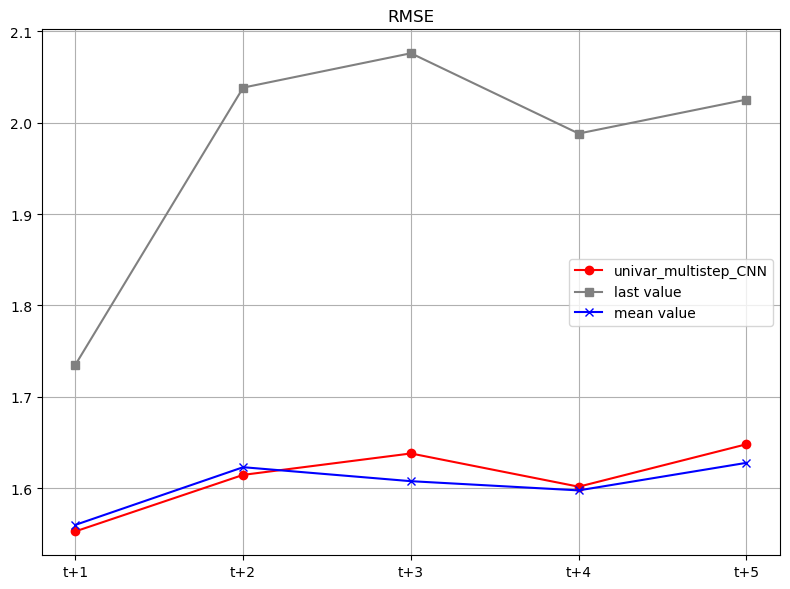

In [44]:
time_labels = ['t+1', 't+2', 't+3', 't+4', 't+5']  # etiquetas de tiempo para ploteo de las metricas RMSE
test_size = int(0.1* len(Tmax))   # se realiza el test en el 10% final de los datos
steps_in = 10  # con cuantos puntos temporales previos  se va hacer el forecasting
steps_out = 5  # los modelos predicen 5 puntos temporales futuros
n_filter = 100 # numero de filtros convulacionales
n_kernel = 5    # tamaño del nerkel
n_epochs = 500   # numero de epocas de entrenamiento
n_batch  = 32    # tamaño del minibatch de entrenamiento

# define configuracion:  [steps_in, steps_out, n_neurons, n_epochs, n_batch]
config = [steps_in, steps_out, n_filter, n_kernel, n_epochs, n_batch]

# Evalua el modelo MLP multivariado multi-step  en walk-forward
score, scores = evaluate_univar_multistep_cnn(Tmax.values, test_size, config)

# imprime score
print('RMSE para mejor modelo CNN univariado: %.3f ' % (score))

# plotea scores
plt.figure(figsize=(8,6))
plt.plot(time_labels, scores, marker='o', color="red", label='univar_multistep_CNN')
plt.plot(time_labels, scores_l, marker='s', color="gray", label="last value")
plt.plot(time_labels, scores_m, marker='x', color="blue", label="mean value")

# show plot
plt.title('RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Según los resultados, el mejor modelo CNN encontrado en la búsqueda de hiperparámetros presenta un RMSE de 1.568, el cual es ligeramente mayor que el encontrado previamente en el modelo univariado LSTM (1.561).

## Modelos multivariados

Se entrenarán modelos neuronales multivariados: MLP y LSTM, con la finalidad de pronosticar los siguientes 5 valores diarios de Tmax en base a los valores pasados de las series del dataset. Estos modelos se evaluarán en walk-forward en el 10% final de la serie.

### MLP

In [37]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force TF to use only the CPU
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')  # obtiene las gpus instaladas
if len(gpus) > 0:   # si hay alguna gpu instalada
    # setea para usar solo la memória de la GPU necesária en tiempo de ejecucion
    tf.config.experimental.set_memory_growth(gpus[0], True)
print(gpus)

[]


Librerias 

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate

Función para generar muestras de entrenamiento

In [39]:
# Funcion para generar secuencias multivariadas de n_steps_in de entrada y steps_out de target a partir de una secuencia multivariada
def split_sequences(sequences, steps_in, steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # calcula el indice del final de la secuencia
        end_ix = i + steps_in  # final de la muestra de entra
        out_end_ix = end_ix + steps_out  # final de la muestra de salida

        # si el indice es mayor que la secuencia entonces deja de generar mas muestras
        if out_end_ix > len(sequences)-1:
            break

        X.append( sequences[i:end_ix, :] ) # añade las secuencias a la lista de muestras de entrada para entrenamiento
        y.append( sequences[end_ix:out_end_ix, 0] ) # añade los siguientes steps_out de secuencia 0 (Global_active_power) como target
    return np.array(X), np.array(y)

Función para entrenar modelo MLP

In [43]:
# Funcion para entrenar el modelo MLP
def multivar_multistep_mlp_fit(train_series, config):
    # desempaca los hiperparámetros de configuración de modelo
    steps_in, steps_out, n_neurons, n_epochs, n_batch = config

    # Genera las muestras de entrenamiento en rolling window a partir de la serie pasada
    # split_sequences()entrega X en la forma [samples, timesteps, features]
    X, y = split_sequences(train_series, steps_in, steps_out)

    # aplana las secuencias de entrada para el modelo MLP
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))


    # define arquitectura de modelo MLP
    modelo = Sequential()
    modelo.add(Dense(n_neurons, activation='relu', input_dim=n_input))
    modelo.add(Dense(steps_out))
    modelo.compile(loss='mse', optimizer='adam')

    # entrena el modelo con la la data de entrenamiento generada
    modelo.fit(X, y, epochs=n_epochs, batch_size=n_batch, verbose = 0)
    return modelo

Función para hacer el forecasting con un modelo MLP ya ajustado en base a las series históricas.

In [41]:
# predice n_steps_out valores siguientes de las serie en history_series con un modelo MLP ya ajustado
def multivar_multistep_mlp_predict(modelo, history_series, config):
    # desempaca los hiperparámetros de configuración de modelo
    steps_in, steps_out, n_neurons, n_epochs, n_batch = config

    # el numero de series es la 2da dimension de history_series (la 1era es el numero de time_steps)
    n_features = history_series.shape[1]

    # extrae la muestra para enviar al modelo MLP para hacer la prediccion (ultimos steps_in puntos temporales de todas las series historicas)
    X_input = history_series[-steps_in:, :]
    X_input = X_input.reshape(1, steps_in * n_features)     # aplana las secuencias de entrada para el modelo MLP

    # predice
    yhat = modelo.predict(X_input, verbose=0)
    return yhat[0]

Función para evaluar en walk-forward un modelo MLP para forecasting multistep con entradas multivariadas.

In [42]:
# evalua el modelo MLP multivariado multi-step en walk-forward
def evaluate_multivar_multistep_mlp(series, test_size, config):
    # desempaca los hiperparámetros de configuración de modelo
    steps_in, steps_out, n_neurons, n_epochs, n_batch = config

    # split las series en train - test
    train_series, test_series = series[0:-test_size, :], series[-test_size:, :]

    # Entrena un modelo multivariado MLP para evaluar en walk-forward (solo se entrena una vez)
    modelo = multivar_multistep_mlp_fit(train_series, config)

    # Inicializa la serie historica con la serie de training para empezar la evaluacion en walk-forward
    history_series = train_series.tolist()

    # walk-forward validation sobre cada semana
    predictions = list()  # array donde se almacenan los vectores de prediccion multistep
    real = list()  # array donde se almacenan los vectores reales para comparar con las predicciones multistep
    for i in range(len(test_series)-steps_out+1): # recorre cada time step de test
        # predice con el modelo
        yhat_sequence = multivar_multistep_mlp_predict(modelo, np.array(history_series), config)
        # almacena la secuencia predicha
        predictions.append(yhat_sequence)
        # adiciona al array real la secuencia que debió salir de la serie 0 (Tmax)
        real.append(test_series[i:i+steps_out, 0])
        # añade un time step de test a history_series para la siguiente iteracion
        history_series.append(test_series[i].tolist())

    predictions = np.array(predictions)
    real = np.array(real)
    # evalua las secuencias predichas de cada día de test (prediccion de Tmax)
    score, scores = evaluate_forecasts(real, predictions)
    return score, scores

**Búsqueda de mejores hiperparámetros MLP - 3 variables**

In [ ]:
time_labels = ['t+1', 't+2', 't+3', 't+4', 't+5']  # etiquetas de tiempo para ploteo de las metricas RMSE
test_size = int(0.1* len(Tmax))   # se realiza el test en el 10% final de los datos
steps_in = [5, 7, 10]  # con cuantos puntos temporales previos  se va hacer el forecasting
steps_out = 5  # los modelos predicen 5 puntos temporales futuros
n_neurons = [400, 500, 600]    # numero de neuronas de la capa oculta de la MLP
n_epochs = 1500   # numero de epocas de entrenamiento
n_batch  = 32    # tamaño del minibatch de entrenamiento

# búsqueda por grilla de mejores hiperparámetros
best_score = float("inf")
best_params = None

for i in steps_in:
    for n in n_neurons:
        # Nueva configuración
        config = [i, steps_out, n, n_epochs, n_batch]
        # Se calcucan los scores
        score, scores = evaluate_multivar_multistep_mlp(np.array(list(zip(Tmax, Tmin, PrecipAcum))), test_size, config)
        # Comparación de mejores hiperparámetros
        if score < best_score:
            best_score = score
            best_params = {"steps_in": i, "n_neurons": n}
            

# imprime score y mejores hiperparámetros
print(f"Mejores hiperparámetros: {best_params}")
print('El mejor score obtenido es: %.3f ' % (best_score))

Mejores hiperparámetros encontrados: {'steps_in': 10, 'n_neurons': 600}
El mejor score obtenido es: 1.575

**Evaluación de mejores hiperparámetros encontrados - 3 variables**

C:\Users\rober\anaconda3\envs\env_robert_series\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


RMSE para mejor modelo MLP con 3 variables (Tmax, Tmin y PrecipAcum): 1.582 


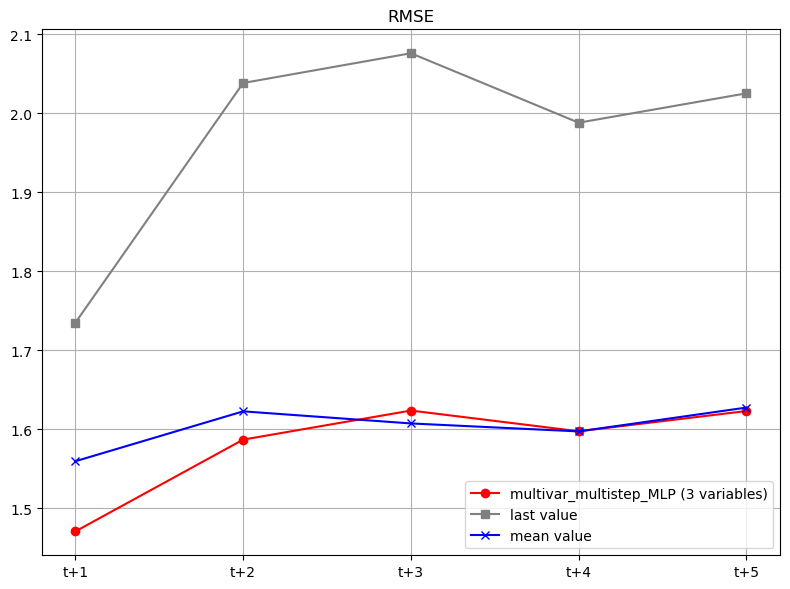

In [75]:
time_labels = ['t+1', 't+2', 't+3', 't+4', 't+5']  # etiquetas de tiempo para ploteo de las metricas RMSE
test_size = int(0.1* len(Tmax))   # se realiza el test en el 10% final de los datos
steps_in = 10  # con cuantos puntos temporales previos  se va hacer el forecasting
steps_out = 5  # los modelos predicen 5 puntos temporales futuros
n_neurons = 600    # numero de neuronas de la capa oculta de la MLP
n_epochs = 1500   # numero de epocas de entrenamiento
n_batch  = 32    # tamaño del minibatch de entrenamiento

# define configuracion:  [steps_in, steps_out, n_neurons, n_epochs, n_batch]
config = [steps_in, steps_out, n_neurons, n_epochs, n_batch]

# Evalua el modelo MLP multivariado multi-step  en walk-forward
score, scores = evaluate_multivar_multistep_mlp(np.array(list(zip(Tmax, Tmin, PrecipAcum))), test_size, config)

# imprime score
print('RMSE para mejor modelo MLP con 3 variables (Tmax, Tmin y PrecipAcum): %.3f ' % (score))

# plotea scores
plt.figure(figsize=(8,6))
plt.plot(time_labels, scores, marker='o', color = "red", label='multivar_multistep_MLP (3 variables)')
plt.plot(time_labels, scores_l, marker='s', color="gray", label="last value")
plt.plot(time_labels, scores_m, marker='x', color="blue", label="mean value")

# show plot
plt.title('RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Para la red neuronal MLP se utilizó un modelo secuencial que consta de dos capas: 
- La primera capa oculta (Dense), es una capa totalmente conectada de 600 neuronas, que recibe como entrada los 10 steps previos; es decir, últimos 10 valores de Tmax, Tmin y PrecipAcum.
- La capa de salida (Dense), presenta 5 neuronas, las cuales son las encargadas de calcular los valores de los 5 steps siguientes; en otras palabras, se calculan los valores de Tmax de los 5 días siguientes.

Con este modelo MLP se obtuvo un RMSE de 1.575, el cual es menor que los valores RMSE de los modelos de persistencia evaluados previamente, ahora, se probará a entrenar otro modelo MLP, pero con 2 variables: Tmax y PrecipAcum.

**Búsqueda de mejores hiperparámetros MLP - 2 variables**

In [ ]:
time_labels = ['t+1', 't+2', 't+3', 't+4', 't+5']  # etiquetas de tiempo para ploteo de las metricas RMSE
test_size = int(0.1* len(Tmax))   # se realiza el test en el 10% final de los datos
steps_in = [5, 7, 10]  # con cuantos puntos temporales previos  se va hacer el forecasting
steps_out = 5  # los modelos predicen 5 puntos temporales futuros
n_neurons = [400, 500, 600]    # numero de neuronas de la capa oculta de la MLP
n_epochs = 1500   # numero de epocas de entrenamiento
n_batch  = 32    # tamaño del minibatch de entrenamiento

# búsqueda por grilla de mejores hiperparámetros
best_score = float("inf")
best_params = None

for i in steps_in:
    for n in n_neurons:
        # Nueva configuración
        config = [i, steps_out, n, n_epochs, n_batch]
        # Se calcucan los scores
        score, scores = evaluate_multivar_multistep_mlp(np.array(list(zip(Tmax, PrecipAcum))), test_size, config)
        # Comparación de mejores hiperparámetros
        if score < best_score:
            best_score = score
            best_params = {"steps_in": i, "n_neurons": n}
            

# imprime score y mejores hiperparámetros
print(f"Mejores hiperparámetros: {best_params}")
print('El mejor score obtenido es: %.3f ' % (best_score))

Mejores hiperparámetros: {'steps_in': 10, 'n_neurons': 500}
El mejor score obtenido es: 1.570 

**Evaluación de mejores hiperparámetros encontrados - 2 variables**

RMSE para mejor modelo MLP con 2 variables (Tmax y PrecipAcum): 1.597 


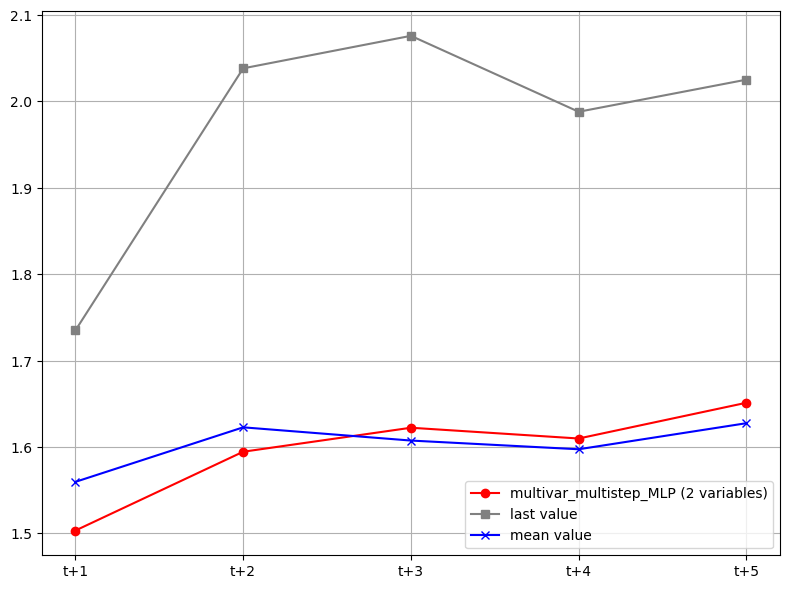

In [77]:
time_labels = ['t+1', 't+2', 't+3', 't+4', 't+5']  # etiquetas de tiempo para ploteo de las metricas RMSE
test_size = int(0.1* len(Tmax))   # se realiza el test en el 10% final de los datos
steps_in = 10  # con cuantos puntos temporales previos  se va hacer el forecasting
steps_out = 5  # los modelos predicen 5 puntos temporales futuros
n_neurons = 500    # numero de neuronas de la capa oculta de la MLP
n_epochs = 1500   # numero de epocas de entrenamiento
n_batch  = 32    # tamaño del minibatch de entrenamiento

# define configuracion:  [steps_in, steps_out, n_neurons, n_epochs, n_batch]
config = [steps_in, steps_out, n_neurons, n_epochs, n_batch]

# Evalua el modelo MLP multivariado multi-step  en walk-forward
score, scores = evaluate_multivar_multistep_mlp(np.array(list(zip(Tmax, PrecipAcum))), test_size, config)

# imprime score
print('RMSE para mejor modelo MLP con 2 variables (Tmax y PrecipAcum): %.3f ' % (score))

# plotea scores
plt.figure(figsize=(8,6))
plt.plot(time_labels, scores, marker='o', color="red", label='multivar_multistep_MLP (2 variables)')
plt.plot(time_labels, scores_l, marker='s', color="gray", label="last value")
plt.plot(time_labels, scores_m, marker='x', color="blue", label="mean value")

# show plot
plt.title('RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Para la red neuronal MLP de 2 variables se utilizó un modelo secuencial que consta de dos capas: 
- La primera capa oculta (Dense), es una capa totalmente conectada de 500 neuronas, que recibe como entrada los 10 steps previos; es decir, últimos 10 valores de Tmax y PrecipAcum.
- La capa de salida (Dense), presenta 5 neuronas, las cuales son las encargadas de calcular los valores de los 5 steps siguientes; en otras palabras, se calculan los valores de Tmax de los 5 días siguientes.

Con este modelo MLP se obtuvo un RMSE de 1.570, el cual es ligeramente menor al modelo MLP con las 3 variables (Tmax, Tmin, PrecipAcum), eso quiere decir que la variable Tmin no es muy importante al momento de realizar las predicciones de Tmax.

### LSTM

In [46]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force TF to use only the CPU
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')  # obtiene las gpus instaladas
if len(gpus) > 0:   # si hay alguna gpu instalada
    # setea para usar solo la memória de la GPU necesária en tiempo de ejecucion
    tf.config.experimental.set_memory_growth(gpus[0], True)
print(gpus)

[]


Librerías

In [47]:
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

Se utilizará la función split_sequences() definida previamente para entrenar los modelos MLP.



Función para entrenar un modelo stacked LSTM

In [48]:
def multivar_multistep_lstm_stacked_fit(train_series, config):
    # desempaca los hiperparámetros de configuración de modelo
    steps_in, steps_out, lstm_units, n_epochs, n_batch = config

    # Genera las muestras de entrenamiento en rolling window a partir de la serie pasada
    # split_sequences() ya garantiza que X esté en la forma [samples, timesteps, features] para entrenar la LSTM
    X, y = split_sequences(train_series, steps_in, steps_out)

    # obtiene el numero de series (tercera dimension de X)
    n_features = X.shape[2]

    # define arquitectura de modelo LSTM
    modelo = Sequential()
    # capa lstm con dimension lstm_units  y secuencias de entrada unidimensionales de n_steps_in pasos
    modelo.add(LSTM(lstm_units, activation='relu', return_sequences=False, input_shape=(steps_in, n_features)))
    #modelo.add(LSTM(lstm_units, activation='relu', return_sequences=False, input_shape=(steps_in, n_features)))
    # segunda capa lstm con dimension de estado = 20
    # modelo.add(LSTM(20, activation='relu'))
    # capa densa de 20 unidades
    modelo.add(Dense(20, activation='relu'))
    # capa de salida con steps_out   unidades de salida
    modelo.add(Dense(steps_out))
    modelo.compile(loss='mse', optimizer='adam')

    # entrena el modelo con la la data de entrenamiento generada
    modelo.fit(X, y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return modelo

Función para predecir los n_steps_out valores siguientes con un modelo stacked LSTM ya ajustado

In [49]:
def multivar_multistep_lstm_stacked_predict(modelo, history_series, config):
    # desempaca los hiperparámetros de configuración de modelo
    steps_in, steps_out, lstm_units, n_epochs, n_batch = config

    # el numero de series es la 2da dimension de history_series (la 1era es el numero de time_steps)
    n_features = history_series.shape[1]

    # prepara la muestra para enviar al modelo CNN para hacer la prediccion (ultimos n_steps_in puntos temporales de todas las series)
    X_input = history_series[-steps_in:, :]
    X_input = X_input.reshape(1, steps_in, n_features)

    # predice
    yhat = modelo.predict(X_input, verbose=0)
    return yhat[0]

Función para evaluar en walk-forward un modelo LSTM para forecasting multistep con entradas multivariadas

In [50]:
def evaluate_multivar_multistep_lstm_stacked(series, test_size, config):
    # desempaca los hiperparámetros de configuración de modelo
    steps_in, steps_out, lstm_units, n_epochs, n_batch = config

    # split las series en train - test
    train_series, test_series = series[0:-test_size, :], series[-test_size:, :]

    # Entrena un modelo multivariado LSTM para evaluar en walk-forward (solo se entrena una vez)
    modelo = multivar_multistep_lstm_stacked_fit(train_series, config)

    # Inicializa la serie historica con la serie de training para empezar la evaluacion en walk-forward
    history_series = train_series.tolist()

    # walk-forward validation sobre cada semana
    predictions = list()  # array donde se almacenan los vectores de prediccion multistep
    real = list()  # array donde se almacenan los vectores reales para comparar con las predicciones multistep
    for i in range(len(test_series)-steps_out+1): # recorre cada time step de test
        # predice con el modelo
        yhat_sequence = multivar_multistep_lstm_stacked_predict(modelo, np.array(history_series), config)
        # almacena la secuencia predicha
        predictions.append(yhat_sequence)
        # adiciona al array real la secuencia que debió salir de la serie 0 (Global_active_power)
        real.append(test_series[i:i+steps_out, 0])
        # añade un time step de test a history_series para la siguiente iteracion
        history_series.append(test_series[i].tolist())

    predictions = np.array(predictions)
    real = np.array(real)
    # evalua las secuencias predichas de cada semana de test (prediccion de Global_active_power)
    score, scores = evaluate_forecasts(real, predictions)
    return score, scores

**Búsqueda de mejores hiperparámetros LSTM - 3 variables**

In [ ]:
time_labels = ['t+1', 't+2', 't+3', 't+4', 't+5']  # etiquetas de tiempo para ploteo de las metricas RMSE
test_size = int(0.1* len(Tmax))   # se realiza el test en el 10% final de los datos
steps_in = [5, 7, 10]  # con cuantos puntos temporales previos  se va hacer el forecasting
steps_out = 5  # los modelos predicen 5 puntos temporales futuros
lstm_units = [50, 100, 150]    # numero de unidades lstm
n_epochs = 1500   # numero de epocas de entrenamiento
n_batch  = 32    # tamaño del minibatch de entrenamiento

# búsqueda por grilla de mejores hiperparámetros
best_score = float("inf")
best_params = None

for i in steps_in:
    for l in lstm_units:
        # Nueva configuración
        config = [i, steps_out, l, n_epochs, n_batch]
        # Se calcucan los scores
        score, scores = evaluate_multivar_multistep_lstm_stacked(np.array(list(zip(Tmax, Tmin, PrecipAcum))), test_size, config)
        # Comparación de mejores hiperparámetros
        if score < best_score:
            best_score = score
            best_params = {"steps_in": i, "lstm_units": l}
            

# imprime score y mejores hiperparámetros
print(f"Mejores hiperparámetros: {best_params}")
print('El mejor score obtenido es: %.3f ' % (best_score))

Mejores hiperparámetros encontrados: {'steps_in': 7, 'lstm_units': 100}

El mejor score obtenido es: 1.564

**Evaluación de mejores hiperparámetros LSTM encontrados - 3 variables**

C:\Users\rober\anaconda3\envs\env_robert_series\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE para mejor modelo LSTM con 3 variables (Tmax, Tmin y PrecipAcum): 1.582 


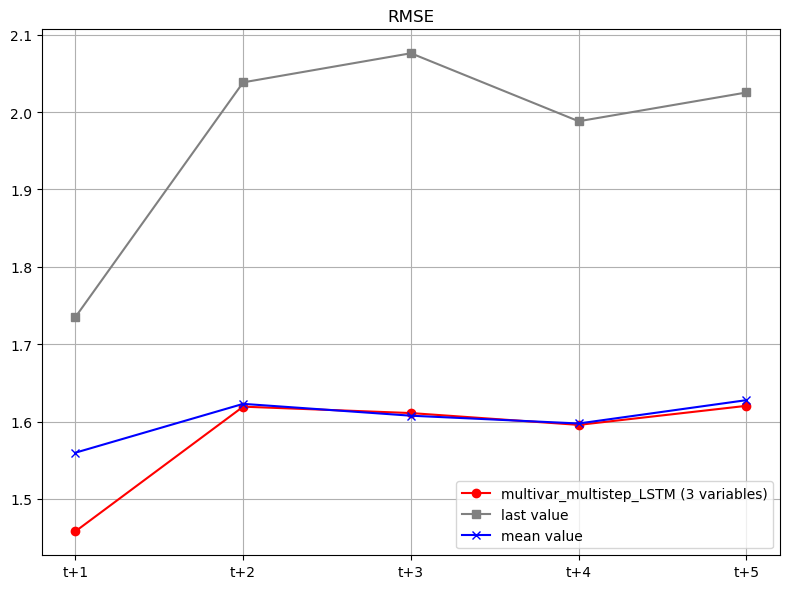

In [79]:
time_labels = ['t+1', 't+2', 't+3', 't+4', 't+5']  # etiquetas de tiempo para ploteo de las metricas RMSE
test_size = int(0.1* len(Tmax))   # se realiza el test en el 10% final de los datos
steps_in = 7  # con cuantos puntos temporales previos  se va hacer el forecasting
steps_out = 5  # los modelos predicen 5 puntos temporales futuros
lstm_units = 100    # numero de unidades LSTM
n_epochs = 1500   # numero de epocas de entrenamiento
n_batch  = 32    # tamaño del minibatch de entrenamiento

# define configuracion:  [steps_in, steps_out, lstm_units, n_epochs, n_batch]
config = [steps_in, steps_out, lstm_units, n_epochs, n_batch]

# Evalua el modelo MLP multivariado multi-step  en walk-forward
score, scores = evaluate_multivar_multistep_lstm_stacked(np.array(list(zip(Tmax, Tmin, PrecipAcum))), test_size, config)

# imprime score
print('RMSE para mejor modelo LSTM con 3 variables (Tmax, Tmin y PrecipAcum): %.3f ' % (score))

# plotea scores
plt.figure(figsize=(8,6))
plt.plot(time_labels, scores, marker='o', color = "red", label='multivar_multistep_LSTM (3 variables)')
plt.plot(time_labels, scores_l, marker='s', color="gray", label="last value")
plt.plot(time_labels, scores_m, marker='x', color="blue", label="mean value")

# show plot
plt.title('RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Para la red neuronal LSTM de 3 variables se utilizó un modelo secuencial que consta de tres capas: 
- La primera capa LSTM, cuenta con 100 celdas de memoria, las cuales son capaces de retener información a lo largo de los timesteps, además, recibe como secuencia de entrada los 7 steps previos de cada variable; es decir, últimos 7 valores de Tmax, Tmin y PrecipAcum.
- La capa intermedia densa, presenta 20 neuronas, las cuales están totalmente conectadas. Cada neurona está conectada a todas las neuronas de la capa LSTM.
- La capa de salida presenta 5 neuronas, la cual es la encargada de predecir los 5 valores futuros para Tmax.

Con este modelo LSTM se obtuvo un RMSE de 1.564, el cual es menor que los valores RMSE de los modelos MLP evaluados previamente, ahora, se probará a entrenar otro modelo LSTM, pero con 2 variables: Tmax y PrecipAcum.

**Búsqueda de mejores hiperparámetros LSTM - 2 variables**

In [53]:
time_labels = ['t+1', 't+2', 't+3', 't+4', 't+5']  # etiquetas de tiempo para ploteo de las metricas RMSE
test_size = int(0.1* len(Tmax))   # se realiza el test en el 10% final de los datos
steps_in = [5, 7, 10]  # con cuantos puntos temporales previos  se va hacer el forecasting
steps_out = 5  # los modelos predicen 5 puntos temporales futuros
lstm_units = [50, 100, 150]    # numero de unidades lstm
n_epochs = 1500   # numero de epocas de entrenamiento
n_batch  = 32    # tamaño del minibatch de entrenamiento

# búsqueda por grilla de mejores hiperparámetros
best_score = float("inf")
best_params = None

for i in steps_in:
    for l in lstm_units:
        # Nueva configuración
        config = [i, steps_out, l, n_epochs, n_batch]
        # Se calcucan los scores
        score, scores = evaluate_multivar_multistep_lstm_stacked(np.array(list(zip(Tmax, PrecipAcum))), test_size, config)
        # Comparación de mejores hiperparámetros
        if score < best_score:
            best_score = score
            best_params = {"steps_in": i, "lstm_units": l}
            

# imprime score y mejores hiperparámetros
print(f"Mejores hiperparámetros: {best_params}")
print('El mejor score obtenido es: %.3f ' % (best_score))

C:\Users\rober\anaconda3\envs\env_robert_series\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\rober\anaconda3\envs\env_robert_series\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\rober\anaconda3\envs\env_robert_series\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\rober\anaconda3\envs\env_robert_series\Lib\site-package

Mejores hiperparámetros: {'steps_in': 10, 'lstm_units': 150}
El mejor score obtenido es: 1.578 


Mejores hiperparámetros encontrados: {'steps_in': 10, 'lstm_units': 150}
El mejor score obtenido es: 1.578 

**Evaluación de mejores hiperparámetros LSTM encontrados - 2 variables**

C:\Users\rober\anaconda3\envs\env_robert_series\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE para mejor modelo LSTM con 2 variables (Tmax y PrecipAcum): 1.597 


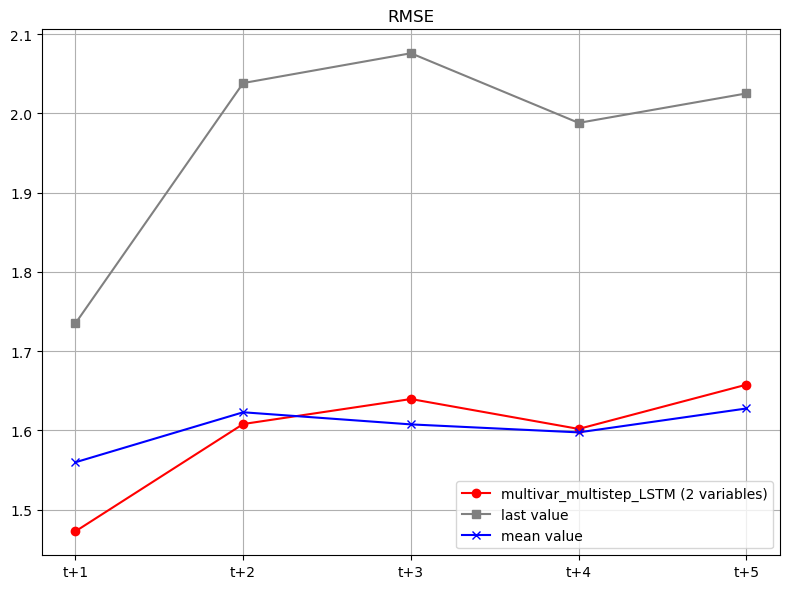

In [80]:
time_labels = ['t+1', 't+2', 't+3', 't+4', 't+5']  # etiquetas de tiempo para ploteo de las metricas RMSE
test_size = int(0.1* len(Tmax))   # se realiza el test en el 10% final de los datos
steps_in = 10  # con cuantos puntos temporales previos  se va hacer el forecasting
steps_out = 5  # los modelos predicen 5 puntos temporales futuros
lstm_units = 150    # numero de unidades LSTM
n_epochs = 1500   # numero de epocas de entrenamiento
n_batch  = 32    # tamaño del minibatch de entrenamiento

# define configuracion:  [steps_in, steps_out, lstm_units, n_epochs, n_batch]
config = [steps_in, steps_out, lstm_units, n_epochs, n_batch]

# Evalua el modelo MLP multivariado multi-step  en walk-forward
score, scores = evaluate_multivar_multistep_lstm_stacked(np.array(list(zip(Tmax, PrecipAcum))), test_size, config)

# imprime score
print('RMSE para mejor modelo LSTM con 2 variables (Tmax y PrecipAcum): %.3f ' % (score))

# plotea scores
plt.figure(figsize=(8,6))
plt.plot(time_labels, scores, marker='o', color="red", label='multivar_multistep_LSTM (2 variables)')
plt.plot(time_labels, scores_l, marker='s', color="gray", label="last value")
plt.plot(time_labels, scores_m, marker='x', color="blue", label="mean value")

# show plot
plt.title('RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Para la red neuronal LSTM de 2 variables se utilizó un modelo secuencial que consta de tres capas: 
- La primera capa LSTM, cuenta con 150 celdas de memoria, las cuales son capaces de retener información a lo largo de los timesteps, además, recibe como secuencia de entrada los 10 steps previos de cada variable; es decir, últimos 10 valores de Tmax y PrecipAcum.
- La capa intermedia densa, presenta 20 neuronas, las cuales están totalmente conectadas. Cada neurona está conectada a todas las neuronas de la capa LSTM.
- La capa de salida presenta 5 neuronas, la cual es la encargada de predecir los 5 valores futuros para Tmax.

Con este modelo LSTM se obtuvo un RMSE de 1.578, el cual es mayor al valor RMSE del modelo LSTM con 3 variables.

## Conclusiones

- Se entrenaron diversos modelos neuronales, donde todos presentan un menor RMSE (< 1.603) que el mejor modelo de persistencia (Mean Value), en otras palabras, todos los modelos entrenados presentan un mejor rendimiento que los modelos de persistencia.
- Aunque los modelos entrenados presentan un mejor rendimiento que los modelos de persistencia, la diferencia no es muy grande, puesto que el mejor modelo encontrado (LSTM Univariado - RSME 1.561), es solo superior al mejor modelo de persistencia por un valor de 0.042.
- En general, los modelos univariados presentan un ligero mejor rendimiento (menor RMSE) que los modelos multivariados; es decir, el resto de variables, PrecipAcum y Tmin, no aportan significativamente a la predicción de la variable Tmax.
- Al inicio se observó que la variable PrecipAcum presentaba muchos outliers, alrededor de 100, esos valores pudieron haber afectado el rendimiento de los modelos multivariados.
- Debido a que no hay demasiada diferencia entre los modelos entrenados y los modelos de persistencia, se podría considerar el uso del modelo de persistencia mean value en un entorno de computación limitado, ya que su valor de RMSE difiere en poca medida con el resto de modelos.